## `Demand Forecasting for E-Commerce`

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Functions

#### Outlier Function

In [5]:
def removeOutlierFunction(row, percentile_5, percentile_95, replace_percentile_5, replace_percentile_95 ):
    if row < percentile_5:
        return replace_percentile_5
    elif row > percentile_95:
        return replace_percentile_95
    else:
        return row

#### Skew Function

In [6]:
def skewValue(Dataframe):
    skewness = Dataframe.skew()
    if skewness > 0:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is positively skewed i.e right skewed. ")
    elif skewness < 0:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is negatively skewed i.e left skewed.")
    else:
        print(f"- {Dataframe.name}: Value of skewness : {skewness} => The data is symmetrical.")

#### Converting function

In [7]:
def convertDataIntoWeekDays_Week_Month(Dataframe, DayIndex, WD_W_M, column):
    df_copy = Dataframe.copy(True)
    df_copy[DayIndex] = pd.to_datetime(df_copy[DayIndex])
    if WD_W_M == 0:
        type = 'Weekday'
        typeNum = 'Weekday_Num'
        df_copy[type] = df_copy[DayIndex].dt.day_name()
        df_copy[typeNum] = df_copy[DayIndex].dt.dayofweek
        weekday_sum = df_copy.groupby([type, typeNum])[column].sum().reset_index()
        weekday_sum_sorted = weekday_sum.sort_values(typeNum).reset_index(drop=True)
        return weekday_sum_sorted
    if WD_W_M == 1:
        typeNum = 'Week_Num'
        df_copy[typeNum] = df_copy[DayIndex].dt.isocalendar().week
        week_sum = df_copy.groupby(typeNum)[column].sum().reset_index()
        week_sum_sorted = week_sum.sort_values(typeNum).reset_index(drop=True)
        # Shuffling
        last_5_rows = week_sum_sorted.iloc[-5:]
        shuffled_last_5 = last_5_rows.sample(frac=1).reset_index(drop=True)
        rest_of_df = week_sum_sorted.iloc[:-5]
        week_sum_new = pd.concat([shuffled_last_5, rest_of_df], ignore_index=True)
        return week_sum_new
    if WD_W_M == 2:
        type = 'Month'
        typeNum = 'Month_Num'
        df_copy[type] = df_copy[DayIndex].dt.month_name()
        df_copy[typeNum] = df_copy[DayIndex].dt.month
        month_sum = df_copy.groupby([type, typeNum])[column].sum().reset_index()
        month_sum_sorted = month_sum.sort_values(typeNum).reset_index(drop=True)
        # Shuffling
        last_row = month_sum_sorted.iloc[-1:]
        shuffled_last = last_row.sample(frac=1).reset_index(drop=True)
        rest_of_df = month_sum_sorted.iloc[:-1]
        month_sum_new = pd.concat([shuffled_last, rest_of_df], ignore_index=True)
        return month_sum_new

#### ADF Test

In [8]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#### KPSS Test

In [9]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

#### LR Model Function

In [10]:
def LRModelResult(X, y):
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size = 0.7, test_size = 0.3)
    lr = LinearRegression()
    lr.fit(X_train.values.reshape(-1,1), y_train.values)
    prediction = lr.predict(X_test.values.reshape(-1,1))
    plt.plot(X_test, prediction, label='Linear Regression', color='b')
    plt.scatter(X_train, y_train, label = "Training Data", color = 'red', alpha=.7)
    plt.scatter(X_test, y_test, label= "Testing Data", color='green', alpha=.7)
    plt.title('Data Spliting and Linear Model')
    plt.legend()
    plt.show()
    print(f'R-square or Score: {lr.score(X_test.values.reshape(-1,1), y_test.values)}')
    print(f'Slope            : {lr.coef_}')

#### AR, MA, ARIMA Model

In [11]:
def AR_MA_ARIMA_Model_TestingAndValidation(p,d,q,Dataframe, col, trainDataSize, testDataSize):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainDataSize * len(product_clicks_impression_temp))
    validation_size = int(testDataSize * len(product_clicks_impression_temp))

    train_data = product_clicks_impression_temp.iloc[:train_size][col]
    validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
    test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

    # ARIMA Model
    order = (p, d, q)
    arima_model = ARIMA(train_data, order=order)
    arima_result = arima_model.fit()

    # Step 6: Forecast using the model
    test_forecast = arima_result.forecast(len(test_data))
    validation_forecast = arima_result.forecast(len(validation_data))

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting 
    plt.plot(date1, train_data.values, label='Actual- Train')
    plt.plot(date2, validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, test_data.values, label='Actual- Test', color='blue')
    
    # Forecaste Plot
    plt.plot(validation_data.index, validation_forecast, label='Forecast- Validation', color='m', linestyle='--')
    plt.plot(test_data.index, test_forecast, label='Forecast- Test', color='red', linestyle='--')

    if p == 0:
        plt.title('MA Train Vs Validation Vs Test Data')
    if q == 0:
        plt.title('AR Train Vs Validation Vs Test Data')
    else:
        plt.title('ARIMA Train Vs Validation Vs Test Data')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    validation_mae = mean_absolute_error(validation_data, validation_forecast)
    validation_mape = mean_absolute_percentage_error(validation_data, validation_forecast)
    validation_rmse = np.sqrt(mean_squared_error(validation_data, validation_forecast))
    valid_r_2 = r2_score(validation_data, validation_forecast)
    n_valid = len(validation_data)
    par = 1
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(test_data, test_forecast)
    test_mape = mean_absolute_percentage_error(test_data, test_forecast)
    test_rmse = np.sqrt(mean_squared_error(test_data, test_forecast))
    test_r_2 = r2_score(test_data, test_forecast)
    n_test = len(test_data)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

    print('Validation Data: ')
    print(f'MAE  : {validation_mae.round(4)}, RMSE  : {validation_rmse.round(4)}, MAPE  : {(validation_mape*100).round(4)}%, R-Square:  {valid_r_2.round(4)},  Adjusted R-Square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}, R-Square : {test_r_2.round(4)}, Adjusted R-Square : {test_adjusted_r_2.round(4)}')
    return arima_result

#### ARIMAX

In [12]:
def ARIMAX_Model(p,d,q,Dataframe, col,exog_cols, trainDataSize, testDataSize):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainDataSize * len(product_clicks_impression_temp))
    validation_size = int(testDataSize * len(product_clicks_impression_temp))

    train_data = product_clicks_impression_temp.iloc[:train_size][col]
    validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
    test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

    # ARIMAX Model
    order = (p, d, q)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][exog_cols]
    arima_model = ARIMA(train_data, order=order,exog=exog_data)
    arima_result = arima_model.fit()

    # Step 6: Forecast using the model
    forecast_test = arima_result.get_forecast(steps=len(test_data), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean
    fitted_values = arima_result.fittedvalues
    forecast_test = arima_result.get_forecast(steps=len(validation_data), exog=exog_data_valid)
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting 
    plt.plot(date1, train_data.values, label='Actual- Train')
    plt.plot(date2, validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, test_data.values, label='Actual- Test', color='blue')
    
    # Forecaste Plot
    plt.plot(test_data.index, forecast_values_test, label='Forecast- Test', color='red', linestyle='--')
    plt.plot(validation_data.index, forecast_values_valid, label='Forecast- Validation', color='m', linestyle='--')

    if p == 0:
        plt.title('MAX Train Vs Validation Vs Test Data')
    if q == 0:
        plt.title('ARX Train Vs Validation Vs Test Data')
    else:
        plt.title('ARIMAX Train Vs Validation Vs Test Data')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

    valid_mae = mean_absolute_error(validation_data, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(validation_data, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(validation_data, forecast_values_valid)
    valid_r_2 = r2_score(validation_data, forecast_values_valid)
    n_valid = len(validation_data)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(test_data, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(test_data, forecast_values_test))
    test_mape = mean_absolute_percentage_error(test_data, forecast_values_test)
    test_r_2 = r2_score(test_data, forecast_values_test)
    n_test = len(test_data)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return arima_result

#### SARIMA

In [13]:
def SARIMA_Model(Dataframe, p, d, q, ratioTest,ratioValidate, attributeQ,SOp,SOd,SOq,SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]
    
    
    order = (p, d, q)
    seasonal_order=(SOp,SOd,SOq,SOseason)

    model = SARIMAX(df_train, order=order,seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_test = model_fit.get_forecast(steps=len(df_test))
    forecast_values_test = forecast_test.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_valid))
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting 
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')
    
    # Forecaste Plot
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = 1
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model_fit

#### SARIMAX Model

##### SARIMAX

In [14]:
def SARIMAX_Model(Dataframe, p, d, q, ratioTest,ratioValidate, attributeQ, exog_cols,SOp,SOd,SOq,SOseason):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(ratioValidate * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]
    df_test = product_clicks_impression_temp.iloc[train_size + validation_size:][attributeQ]
    
    
    order = (p, d, q)
    seasonal_order=(SOp,SOd,SOq,SOseason)
    exog_data = product_clicks_impression_temp.iloc[:train_size][exog_cols]
    exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][exog_cols]
    exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][exog_cols]

    model = SARIMAX(df_train, order=order, exog=exog_data,seasonal_order=seasonal_order)
    model_fit = model.fit()

    forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
    forecast_values_test = forecast_test.predicted_mean
    forecast_test = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
    forecast_values_valid = forecast_test.predicted_mean

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index
    # Actual values plotting 
    plt.plot(date1, df_train.values, label='Actual- Train')
    plt.plot(date2, df_valid.values, label='Actual- Validation', color='green')
    plt.plot(date3, df_test.values, label='Actual- Test', color='blue')
    
    # Forecaste Plot
    plt.plot(df_test.index, forecast_values_test, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(df_valid.index, forecast_values_valid, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(df_valid, forecast_values_valid)
    valid_rmse = np.sqrt(mean_squared_error(df_valid, forecast_values_valid))
    valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
    valid_r_2 = r2_score(df_valid, forecast_values_valid)
    n_valid = len(df_valid)
    par = len(exog_cols)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

    test_mae = mean_absolute_error(df_test, forecast_values_test)
    test_rmse = np.sqrt(mean_squared_error(df_test, forecast_values_test))
    test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
    test_r_2 = r2_score(df_test, forecast_values_test)
    n_test = len(df_test)
    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model_fit

##### Iterative SARIMAX

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def SARIMAX_IterativeModel(Dataframe, p, d, q, SOp, SOd, SOq, SOseason, ratioTest, validationRatio, attributeQ, startModelNo, EndModelNo, subsets):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = product_clicks_impression_temp.set_index('Day Index')  # Corrected

    train_size = int(ratioTest * len(product_clicks_impression_temp))
    validation_size = int(validationRatio * len(product_clicks_impression_temp))

    df_train = product_clicks_impression_temp.iloc[:train_size][attributeQ]
    df_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][attributeQ]  # Corrected
    df_test = product_clicks_impression_temp.iloc[train_size+validation_size:][attributeQ]  # Corrected

    exog_cols = subsets[startModelNo:EndModelNo]

    list_mape = []
    order = (p, d, q)
    seasonal_order = (SOp, SOd, SOq, SOseason)

    for col in exog_cols:
        exog_data = product_clicks_impression_temp.iloc[:train_size][col]
        exog_data_valid = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][col]
        exog_data_test = product_clicks_impression_temp.iloc[train_size+validation_size:][col]

        model = SARIMAX(df_train, order=order, exog=exog_data, seasonal_order=seasonal_order)
        model_fit = model.fit()

        forecast_valid = model_fit.get_forecast(steps=len(df_valid), exog=exog_data_valid)
        forecast_values_valid = forecast_valid.predicted_mean

        forecast_test = model_fit.get_forecast(steps=len(df_test), exog=exog_data_test)
        forecast_values_test = forecast_test.predicted_mean

        valid_mape = mean_absolute_percentage_error(df_valid, forecast_values_valid)
        valid_r_2 = r2_score(df_valid, forecast_values_valid)
        n_valid = len(df_valid)
        par = len(col)
        valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - par - 1)

        test_mape = mean_absolute_percentage_error(df_test, forecast_values_test)
        test_r_2 = r2_score(df_test, forecast_values_test)
        n_test = len(df_test)
        test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - par - 1)

        list_mape.append((col, test_mape, test_r_2, test_adjusted_r_2, valid_mape, valid_r_2, valid_adjusted_r_2))

    return list_mape


#### MLR : Multi Linear Regression

In [92]:
def MLR_Model(Dataframe, target, trainRatio, validationRatio, colList):
    product_clicks_impression_temp = Dataframe.copy()
    product_clicks_impression_temp = Dataframe.set_index('Day Index')
    train_size = int(trainRatio * len(product_clicks_impression_temp))
    validation_size = int(validationRatio * len(product_clicks_impression_temp))

    X_train_data = product_clicks_impression_temp.iloc[:train_size][colList]
    Y_train_data = product_clicks_impression_temp.iloc[:train_size][target]
    X_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][colList]
    Y_validation_data = product_clicks_impression_temp.iloc[train_size:train_size+validation_size][target]
    X_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][colList]
    Y_test_data = product_clicks_impression_temp.iloc[train_size+validation_size:][target]

    # Train the model
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)

    valid_predict = model.predict(X_validation_data)
    test_predict = model.predict(X_test_data)

    plt.figure(figsize=(20, 5))
    date1 = product_clicks_impression_temp.iloc[:train_size].index
    date2 = product_clicks_impression_temp.iloc[train_size:train_size+validation_size].index
    date3 = product_clicks_impression_temp.iloc[train_size+validation_size:].index

    # Actual values plotting 
    plt.plot(date1, Y_train_data.values, label='Actual- Train')
    plt.plot(date2, Y_validation_data.values, label='Actual- Validation', color='green')
    plt.plot(date3, Y_test_data.values, label='Actual- Test', color='blue')
    
    # Forecaste Plot
    plt.plot(Y_test_data.index, test_predict, label='Forecast- Test', color='m', linestyle='--')
    plt.plot(Y_validation_data.index, valid_predict, label='Forecast- Validation', color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()
    valid_mae = mean_absolute_error(Y_validation_data, valid_predict)
    valid_rmse = np.sqrt(mean_squared_error(Y_validation_data, valid_predict))
    valid_mape = mean_absolute_percentage_error(Y_validation_data, valid_predict)
    valid_r_2 = r2_score(Y_validation_data, valid_predict)
    n_valid = len(Y_validation_data)
    p = len(colList)
    valid_adjusted_r_2 = 1 - (1 - valid_r_2) * (n_valid - 1) / (n_valid - p - 1)

    test_mae = mean_absolute_error(Y_test_data, test_predict)
    test_rmse = np.sqrt(mean_squared_error(Y_test_data, test_predict))
    test_mape = mean_absolute_percentage_error(Y_test_data, test_predict)
    test_r_2 = r2_score(Y_test_data, test_predict)
    n_test = len(Y_test_data)

    test_adjusted_r_2 = 1 - (1 - test_r_2) * (n_test - 1) / (n_test - p - 1)
    print('Validation Data: ')
    print(f'MAE  : {valid_mae.round(4)}, RMSE  : {valid_rmse.round(4)}, MAPE  : {(valid_mape*100).round(4)}%, R-square  : {valid_r_2.round(4)}, Adjusted R-square  : {valid_adjusted_r_2.round(4)}')
    print('Test Data: ')
    print(f'MAE  : {test_mae.round(4)}, RMSE  : {test_rmse.round(4)}, MAPE  : {(test_mape*100).round(4)}%, R-square  : {test_r_2.round(4)}, Adjusted R-square  : {test_adjusted_r_2.round(4)}')
    return model

### Importing and merging Data

In [18]:
data_product_A = pd.read_excel(r'Data\ProductA.xlsx')
data_google_clicks = pd.read_excel(r'Data\ProductA_google_clicks.xlsx')
data_facebook_impressions = pd.read_excel(r'Data\ProductA_fb_impressions.xlsx')

In [19]:
merged_df = pd.merge(data_product_A, data_google_clicks, on='Day Index', how='left')
product_clicks_impression = pd.merge(merged_df, data_facebook_impressions, on='Day Index', how='left')
product_clicks_impression

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678
...,...,...,...,...
207,2022-06-26,13,114,1218
208,2022-06-27,16,106,1311
209,2022-06-28,13,109,885
210,2022-06-29,16,60,1000


In [20]:
print("Shpae of dataframe: ",product_clicks_impression.shape, "\n")

Shpae of dataframe:  (212, 4) 



In [21]:
print("Data Info :")
product_clicks_impression.info()

Data Info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


In [22]:
print("Null Values check:")
print(product_clicks_impression.isnull().sum(), "\n")

Null Values check:
Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64 



In [23]:
print("Data Details:")
print(product_clicks_impression.describe(), "\n")

Data Details:
                 Day Index    Quantity     Clicks  Impressions
count                  212  212.000000  212.00000   212.000000
mean   2022-03-16 12:00:00   17.542453  358.20283  1531.702830
min    2021-12-01 00:00:00    5.000000   60.00000   620.000000
25%    2022-01-22 18:00:00   13.750000  154.00000  1209.750000
50%    2022-03-16 12:00:00   17.000000  402.50000  1460.000000
75%    2022-05-08 06:00:00   21.000000  492.75000  1862.000000
max    2022-06-30 00:00:00   38.000000  726.00000  2707.000000
std                    NaN    5.790423  164.52160   440.660783 



- Data consist of 212 rows and 4 columns
- No null values

#### Functions

In [24]:
# Daily
def daily():
    plt.figure(figsize=(24,6))
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Quantity'].div(1000), color = 'orange', marker = 'o', label= 'Quantity',markerfacecolor = '#42adf5')
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Impressions'].div(100000), color = 'r', marker = 'o', label='Impressions', markerfacecolor = '#42adf5')
    plt.plot(product_clicks_impression['Day Index'], product_clicks_impression['Clicks'].div(30000), color = 'm', marker = 'o', label = 'Clicks',markerfacecolor = '#42adf5')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(16,6))
    dates = product_clicks_impression['Day Index']
    x1 = np.array([i for i in range(0, len(dates))])
    y1 = product_clicks_impression['Quantity'].div(product_clicks_impression['Quantity'].mean())
    y2 = product_clicks_impression['Impressions'].div(product_clicks_impression['Impressions'].mean())
    y3 = product_clicks_impression['Clicks'].div(product_clicks_impression['Clicks'].mean())
    X_Y_Spline1 = make_interp_spline(x1, y1)
    X_Y_Spline2 = make_interp_spline(x1, y2)
    X_Y_Spline3 = make_interp_spline(x1, y3)
    X_ = np.linspace(0, len(dates) - 1, 212)
    Y1_ = X_Y_Spline1(X_)
    Y2_ = X_Y_Spline2(X_)
    Y3_ = X_Y_Spline3(X_)
    date_labels = pd.to_datetime(dates.iloc[np.linspace(0, len(dates) - 1, 212).astype(int)])
    plt.plot(date_labels, Y1_, label='Quantity')
    plt.plot(date_labels, Y2_, label='Impressions')
    plt.plot(date_labels, Y3_, label='Clicks')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate() 
    plt.grid(True)
    plt.title("Comparison after smoothing")
    plt.legend(loc='best')
    plt.show()

In [25]:
# Week-days
def weekdays():
    weekday_sum_sorted_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Quantity')
    weekday_sum_sorted_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Impressions')
    weekday_sum_sorted_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 0, 'Clicks')
    merged_df = pd.merge(weekday_sum_sorted_quantity, weekday_sum_sorted_impressions, on=['Weekday', 'Weekday_Num'], how='left')
    weekday_sum_Quantity_Impressions_Clicks = pd.merge(merged_df, weekday_sum_sorted_clicks, on=['Weekday', 'Weekday_Num'], how='left')
    # print(weekday_sum_Quantity_Impressions_Clicks)

    figure, axis = plt.subplots(4, 1,figsize=(12,12))
    axis[0].bar(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'], width=0.6, color = 'orange')
    for i in range(len(weekday_sum_sorted_quantity['Weekday'])):
        axis[0].text(i, weekday_sum_sorted_quantity['Quantity'][i], weekday_sum_sorted_quantity['Quantity'][i], ha = 'center')
    axis[0].plot(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'], color = 'b', marker = 'o',markerfacecolor = 'red', label= 'Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(400, 600)
    axis[0].grid(True)
    axis[1].bar(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'], width=0.6, color = 'm')
    for i in range(len(weekday_sum_sorted_impressions['Weekday'])):
        axis[1].text(i, weekday_sum_sorted_impressions['Impressions'][i], weekday_sum_sorted_impressions['Impressions'][i], ha = 'center')
    axis[1].plot(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'], color = 'b', marker = 'o', markerfacecolor = 'red',label='Impressions')
    axis[1].set_ylim(43000, 50000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].grid(True)
    axis[2].bar(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'], width=0.6, color = 'c')
    for i in range(len(weekday_sum_sorted_clicks['Weekday'])):
        axis[2].text(i, weekday_sum_sorted_clicks['Clicks'][i], weekday_sum_sorted_clicks['Clicks'][i], ha = 'center')
    axis[2].set_ylim(10000, 12000)
    axis[2].plot(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'], color = 'b', marker = 'o',markerfacecolor = 'red', label = 'Clicks')
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].grid(True)
    axis[3].plot(weekday_sum_sorted_quantity['Weekday'], weekday_sum_sorted_quantity['Quantity'].div(1000), color = 'orange', marker = 'o', label= 'Quantity')
    axis[3].plot(weekday_sum_sorted_impressions['Weekday'], weekday_sum_sorted_impressions['Impressions'].div(100000), color = 'r', marker = 'o', label='Impressions')
    axis[3].plot(weekday_sum_sorted_clicks['Weekday'], weekday_sum_sorted_clicks['Clicks'].div(30000), color = 'm', marker = 'o', label = 'Clicks')
    axis[3].legend(loc='best')
    axis[3].grid(True)
    plt.show()
    return weekday_sum_Quantity_Impressions_Clicks

In [26]:
# Week wise
def weekwise():
    weekwise_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Quantity')
    weekwise_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Impressions')
    weekwise_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 1, 'Clicks')
    merged_df = pd.merge(weekwise_quantity, weekwise_impressions, on='Week_Num', how='left')
    weekwise_sum_Quantity_Impressions_Clicks = pd.merge(merged_df, weekwise_clicks, on='Week_Num', how='left')
    # print(weekwise_sum_Quantity_Impressions_Clicks)

    # colors = ['b','g','r','c','m','y','k']
    figure, axis = plt.subplots(4, 1,figsize=(16,12))
    axis[0].bar(weekwise_quantity.index, weekwise_quantity['Quantity'], width=0.8, color = 'orange')
    for i in range(len(weekwise_quantity['Week_Num'])):
        axis[0].text(i, weekwise_quantity['Quantity'][i], weekwise_quantity['Quantity'][i], ha = 'center')
    axis[0].plot(weekwise_quantity.index, weekwise_quantity['Quantity'], color = 'b', marker = 'o',markerfacecolor = 'red', label= 'Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(40, 180)
    axis[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],[48, 49, 50, 51, 52,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
    # axis[0].set_xticks(range(len(weekwise_quantity['Week_Num'])))
    # axis[0].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[0].grid(True)
    axis[1].bar(weekwise_impressions.index, weekwise_impressions['Impressions'], width=0.8, color = 'm')
    for i in range(len(weekwise_impressions['Week_Num'])):
        axis[1].text(i, weekwise_impressions['Impressions'][i], weekwise_impressions['Impressions'][i], ha = 'center')
    axis[1].plot(weekwise_impressions.index, weekwise_impressions['Impressions'], color = 'b', marker = 'o', markerfacecolor = 'red',label='Impressions')
    axis[1].set_ylim(3800, 16000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].grid(True)
    axis[2].bar(weekwise_clicks.index, weekwise_clicks['Clicks'], width=0.8, color = 'c')
    for i in range(len(weekwise_clicks['Week_Num'])):
        axis[2].text(i, weekwise_clicks['Clicks'][i], weekwise_clicks['Clicks'][i], ha = 'center')
    axis[2].set_ylim(300, 4200)
    axis[2].plot(weekwise_clicks.index, weekwise_clicks['Clicks'], color = 'b', marker = 'o',markerfacecolor = 'red', label = 'Clicks')
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].grid(True)
    axis[3].plot(weekwise_quantity.index, weekwise_quantity['Quantity'].div(200), color = 'orange', marker = 'o', label= 'Quantity')
    axis[3].plot(weekwise_impressions.index, weekwise_impressions['Impressions'].div(14000), color = 'r', marker = 'o', label='Impressions')
    axis[3].plot(weekwise_clicks.index, weekwise_clicks['Clicks'].div(5000), color = 'm', marker = 'o', label = 'Clicks')
    axis[3].legend(loc='best')
    axis[3].grid(True)
    plt.show()
    return weekwise_sum_Quantity_Impressions_Clicks

In [27]:
def months(product_clicks_impression):
    month_quantity = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Quantity')
    month_impressions = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Impressions')
    month_clicks = convertDataIntoWeekDays_Week_Month(product_clicks_impression, 'Day Index', 2, 'Clicks')
    
    merged_df = pd.merge(month_quantity, month_impressions, on=['Month', 'Month_Num'], how='left')
    month_Quantity_Impressions_Clicks = pd.merge(merged_df, month_clicks, on=['Month', 'Month_Num'], how='left')
    
    figure, axis = plt.subplots(4, 1, figsize=(12, 12))
    
    # Plotting Quantity
    axis[0].bar(month_quantity.index, month_quantity['Quantity'], width=0.8, color='orange')
    for i in range(len(month_quantity['Month'])):
        axis[0].text(i, month_quantity['Quantity'][i], month_quantity['Quantity'][i], ha='center')
    axis[0].plot(month_quantity.index, month_quantity['Quantity'], color='b', marker='o', markerfacecolor='red', label='Quantity')
    axis[0].set_ylabel('Quantity')
    axis[0].legend(loc='best')
    axis[0].set_ylim(400, 700)
    axis[0].set_xticks(range(len(month_quantity['Month'])))
    axis[0].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[0].grid(True)
    axis[0].set_title('Monthly Quantity')
    
    # Plotting Impressions
    axis[1].bar(month_impressions.index, month_impressions['Impressions'], width=0.8, color='m')
    for i in range(len(month_impressions['Month'])):
        axis[1].text(i, month_impressions['Impressions'][i], month_impressions['Impressions'][i], ha='center')
    axis[1].plot(month_impressions.index, month_impressions['Impressions'], color='b', marker='o', markerfacecolor='red', label='Impressions')
    axis[1].set_ylim(31000, 53000)
    axis[1].legend(loc='best')
    axis[1].set_ylabel('Impressions')
    axis[1].set_xticks(range(len(month_impressions['Month'])))
    axis[1].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[1].grid(True)
    axis[1].set_title('Monthly Impressions')
    
    # Plotting Clicks
    axis[2].bar(month_clicks.index, month_clicks['Clicks'], width=0.8, color='c')
    for i in range(len(month_clicks['Month'])):
        axis[2].text(i, month_clicks['Clicks'][i], month_clicks['Clicks'][i], ha='center')
    axis[2].plot(month_clicks.index, month_clicks['Clicks'], color='b', marker='o', markerfacecolor='red', label='Clicks')
    axis[2].set_ylim(3300, 16000)
    axis[2].set_ylabel('Clicks')
    axis[2].legend(loc='best')
    axis[2].set_xticks(range(len(month_clicks['Month'])))
    axis[2].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[2].grid(True)
    axis[2].set_title('Monthly Clicks')
    
    # Plotting Normalized Data
    axis[3].plot(month_quantity.index, month_quantity['Quantity'].div(400), color='g', marker='o', label='Quantity')
    axis[3].plot(month_impressions.index, month_impressions['Impressions'].div(35000), color='r', marker='o', label='Impressions')
    axis[3].plot(month_clicks.index, month_clicks['Clicks'].div(8200), color='m', marker='o', label='Clicks')
    axis[3].legend(loc='best')
    axis[3].set_xticks(range(len(month_quantity['Month'])))
    axis[3].set_xticklabels(['December', 'January', 'February', 'March', 'April', 'May', 'June'])
    axis[3].grid(True)
    axis[3].set_title('Normalized Monthly Data')
    
    plt.tight_layout()
    plt.show()
    return month_Quantity_Impressions_Clicks

### Outlier check

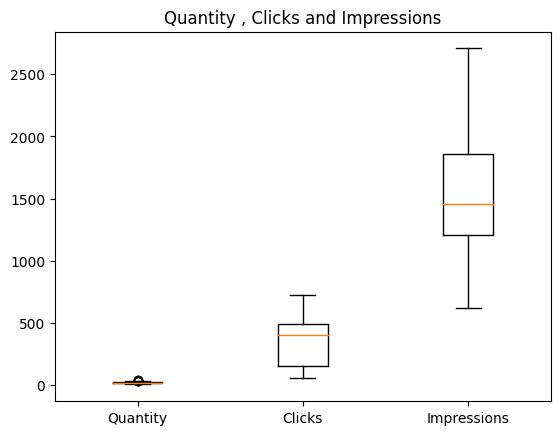

In [28]:
plt.figure(3)
plt.boxplot([product_clicks_impression['Quantity'], product_clicks_impression['Clicks'], product_clicks_impression['Impressions']])
plt.title('Quantity , Clicks and Impressions')
plt.xticks([1,2,3], ['Quantity', 'Clicks', 'Impressions'])
plt.show()

- Quantity has outliers

### Imputing Data and Removing Outliers

##### IQR, 95 Percentile and 5 Percentile

In [29]:
Q1 = np.percentile(product_clicks_impression['Quantity'], 25)
Q3 = np.percentile(product_clicks_impression['Quantity'], 75)
p_95 = np.percentile(product_clicks_impression['Quantity'], 95)
p_96 = np.percentile(product_clicks_impression['Quantity'], 96)
p_97 = np.percentile(product_clicks_impression['Quantity'], 97)
p_98 = np.percentile(product_clicks_impression['Quantity'], 98)
p_99 = np.percentile(product_clicks_impression['Quantity'], 99)
p_5 = np.percentile(product_clicks_impression['Quantity'], 5)
IQR = Q3 - Q1
quantity_mean = product_clicks_impression['Quantity'].mean()
quantity_mode = product_clicks_impression['Quantity'].mode()[0]
quantity_median = product_clicks_impression['Quantity'].median()

print(f"Mean : {quantity_mean}")
print(f"Mode : {quantity_mode}")
print(f"Median : {quantity_median}")
print('-------------------------------------')
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print('-------------------------------------')
print(f"5 -Percentile value: {p_5}")
print(f"95-Percentile value: {p_95}")
print(f"96-Percentile value: {p_96}")
print(f"97-Percentile value: {p_97}")
print(f"98-Percentile value: {p_98}")
print(f"99-Percentile value: {p_99}")


Mean : 17.54245283018868
Mode : 15
Median : 17.0
-------------------------------------
Q1: 13.75
Q3: 21.0
IQR: 7.25
-------------------------------------
5 -Percentile value: 9.0
95-Percentile value: 27.44999999999999
96-Percentile value: 28.560000000000002
97-Percentile value: 30.669999999999987
98-Percentile value: 31.78
99-Percentile value: 35.66999999999996


##### Replacing outliers with - 95 & 5 Percentile values

In [30]:
product_clicks_impression['Quantity_new_95_5'] = product_clicks_impression['Quantity'].apply(lambda x: removeOutlierFunction(x, p_5, p_95,p_5, p_95))

##### Replacing outliers with - 97 & 5 Percentile values

In [31]:
product_clicks_impression['Quantity_new_97_5'] = product_clicks_impression['Quantity'].apply(lambda x: removeOutlierFunction(x, p_5, p_97,p_5, p_97))

#### After removing or imputing Outliers & Shift in Data frequency

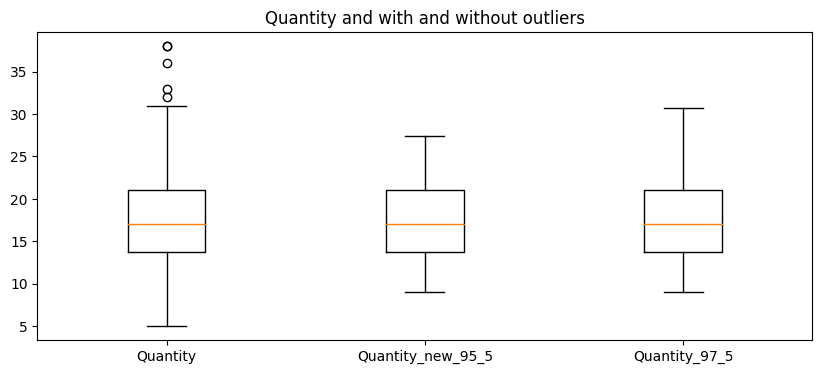

In [32]:
quantityTitles = [product_clicks_impression['Quantity'], product_clicks_impression['Quantity_new_95_5'],product_clicks_impression['Quantity_new_97_5']]
plt.figure(3,figsize=(10,4))
plt.boxplot(quantityTitles)
plt.title('Quantity and with and without outliers')
plt.xticks([1,2,3], ['Quantity', 'Quantity_new_95_5', 'Quantity_97_5'])
plt.show()

**Note:**
- The `Quantity_new_95_5` and `Quantity_97_5` column values which are greater than **95-Percentile** and **97-Percentile** are repalced by **95-Percentile** and **97-Percentile** respectively

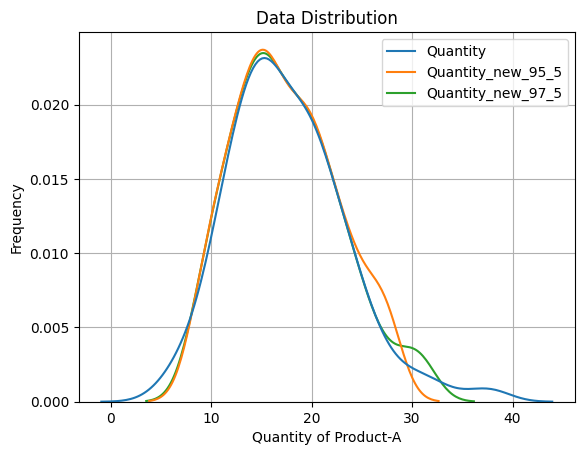

In [33]:
sns.kdeplot(quantityTitles)
plt.title('Data Distribution')
plt.xlabel('Quantity of Product-A')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Note:**
- `Quantity` feature is more normalized after outlier imputation and removal

### Feature Engineering

In [34]:
product_clicks_impression_update = product_clicks_impression.copy(True)
product_clicks_impression_update['Day Index'] = pd.to_datetime(product_clicks_impression_update['Day Index'])
product_clicks_impression_update['Weekday'] = product_clicks_impression_update['Day Index'].dt.day_name()
product_clicks_impression_update['Week'] = product_clicks_impression_update['Day Index'].dt.isocalendar().week
product_clicks_impression_update['Week'] = product_clicks_impression_update['Week'].astype(str)
product_clicks_impression_update['Month'] = product_clicks_impression_update['Day Index'].dt.month_name()
# product_clicks_impression_update['Quater'] = product_clicks_impression_update['Day Index'].dt.quarter
# product_clicks_impression_update['Quater'] = product_clicks_impression_update['Quater'].astype(str)
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'
product_clicks_impression_update['Season'] = product_clicks_impression_update['Day Index'].apply(get_season)
product_clicks_impression_update['Weekday'] = product_clicks_impression_update['Day Index'].dt.day_name()
product_clicks_impression_update['Is_Weekend'] = product_clicks_impression_update['Weekday'].isin(['Saturday', 'Sunday'])
product_clicks_impression_update['Is_Weekday'] = ~product_clicks_impression_update['Is_Weekend']

product_clicks_impression_update_partical_copy = product_clicks_impression_update.copy(True)
del product_clicks_impression_update_partical_copy['Weekday']
del product_clicks_impression_update_partical_copy['Month']
product_clicks_impression_update_partical_copy['Weekday1'] = product_clicks_impression_update_partical_copy['Day Index'].dt.day_of_week
product_clicks_impression_update_partical_copy['Month1'] = product_clicks_impression_update_partical_copy['Day Index'].dt.month
print("Shape before encoding:", product_clicks_impression_update.shape)
product_clicks_impression_update = pd.get_dummies(product_clicks_impression_update, columns=['Weekday', 'Week', 'Month','Season'])
print("Shape after encoding:", product_clicks_impression_update.shape)
# product_clicks_impression_update.head()

Shape before encoding: (212, 12)
Shape after encoding: (212, 56)


In [35]:
bool_columns = product_clicks_impression_update.select_dtypes(include=['bool']).columns
product_clicks_impression_update[bool_columns] = product_clicks_impression_update[bool_columns].astype(int)
product_clicks_impression_update.head()

,Day Index,Quantity,Clicks,Impressions,Quantity_new_95_5,Quantity_new_97_5,Is_Weekend,Is_Weekday,Weekday_Friday,Weekday_Monday,...,Month_April,Month_December,Month_February,Month_January,Month_June,Month_March,Month_May,Season_Spring,Season_Summer,Season_Winter
0,2021-12-01,14,445,620,14.00,14.00,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
1,2021-12-02,10,433,890,10.00,10.00,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,2021-12-03,13,424,851,13.00,13.00,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
3,2021-12-04,22,427,881,22.00,22.00,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,2021-12-05,33,451,678,27.45,30.67,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


### How Quantity, Impressions and Clicks are related:

#### Impressions vs Quantity

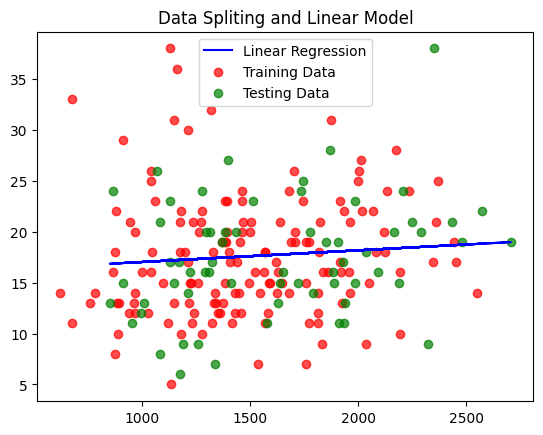

R-square or Score: 0.03751726367821351
Slope            : [0.00114528]


In [36]:
LRModelResult(X = product_clicks_impression['Impressions'],y = product_clicks_impression['Quantity'])

#### Clicks vs Quantity

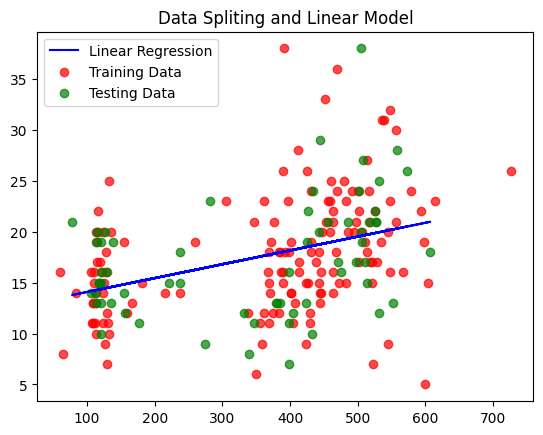

R-square or Score: 0.1311079058175464
Slope            : [0.01359553]


In [37]:
LRModelResult(X = product_clicks_impression['Clicks'],y = product_clicks_impression['Quantity'])

#### Impressions vs Clicks

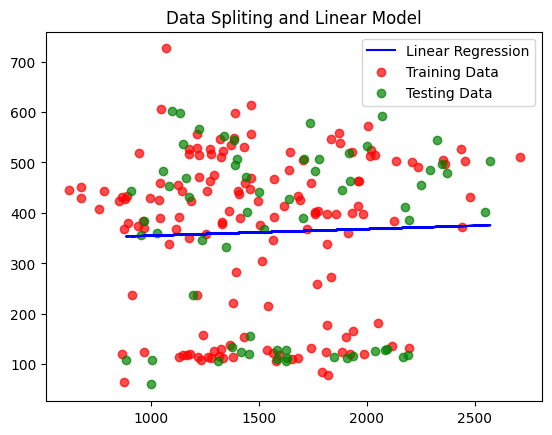

R-square or Score: -0.002970186202128522
Slope            : [0.01312569]


In [38]:
LRModelResult(X = product_clicks_impression['Impressions'],y = product_clicks_impression['Clicks'])

### Correlation:

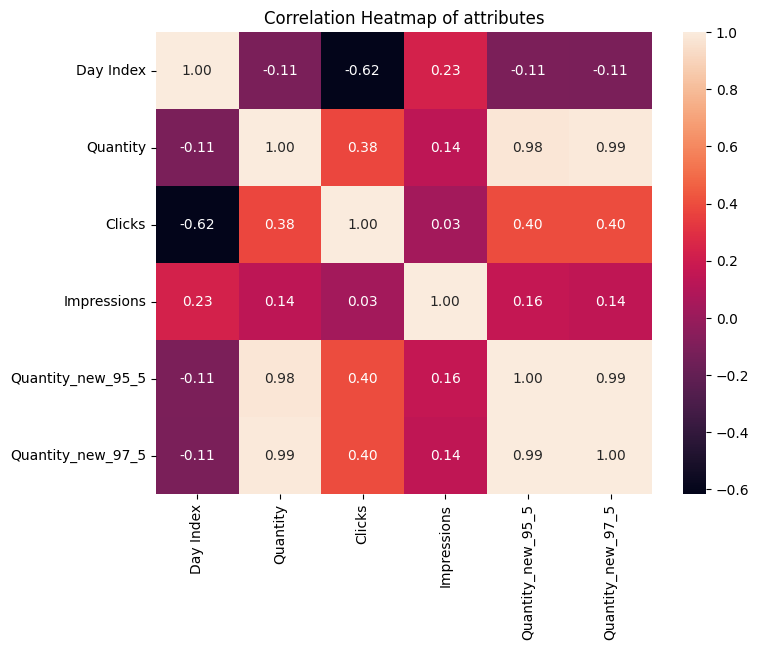

In [39]:
correlation_matrix = product_clicks_impression.corr("pearson")
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap of attributes')
plt.show()

**Note:** 
- Positive increase in correlation between `Quantity`,`Quantity_new_95_5`, `Quantity_new_97_5` and `Clicks`
- Similar goes for correlation between `Quantity` , `Quantity_new_95_5` and `Impressions`

### Data visualization

#### Daily

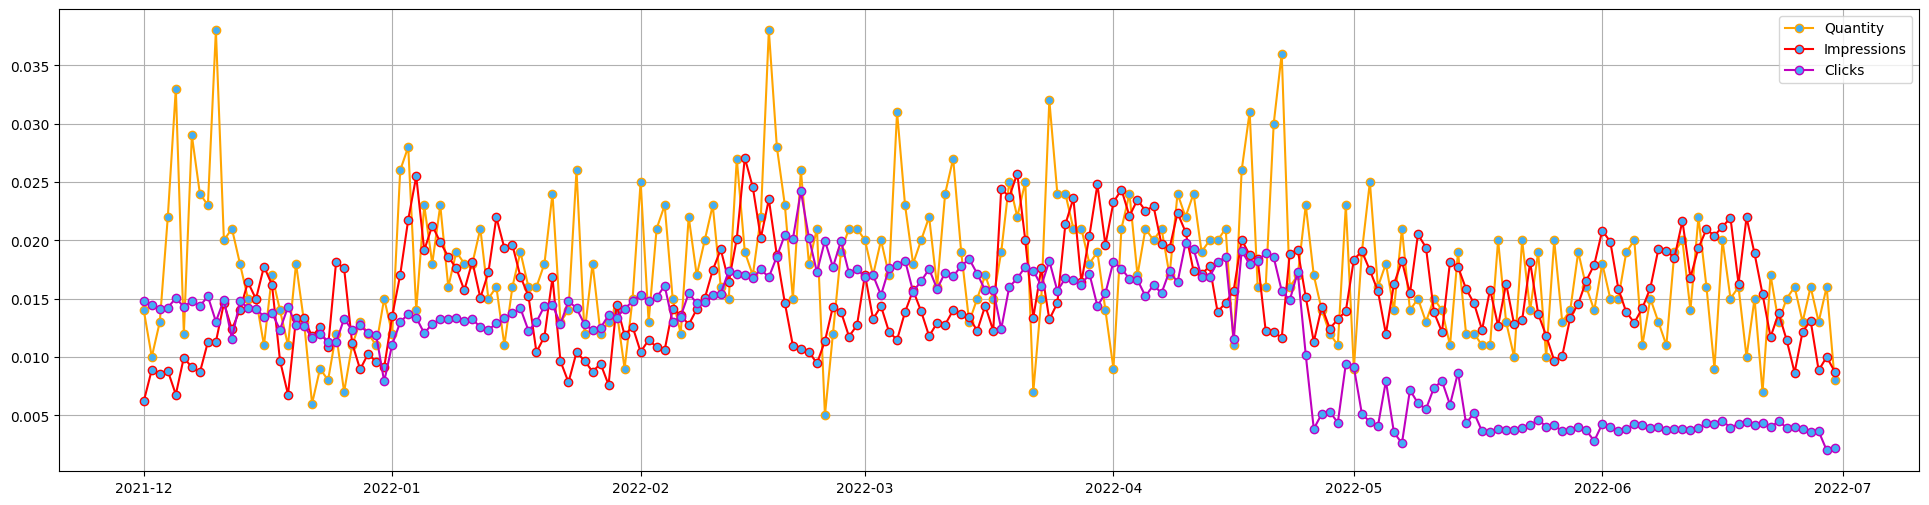

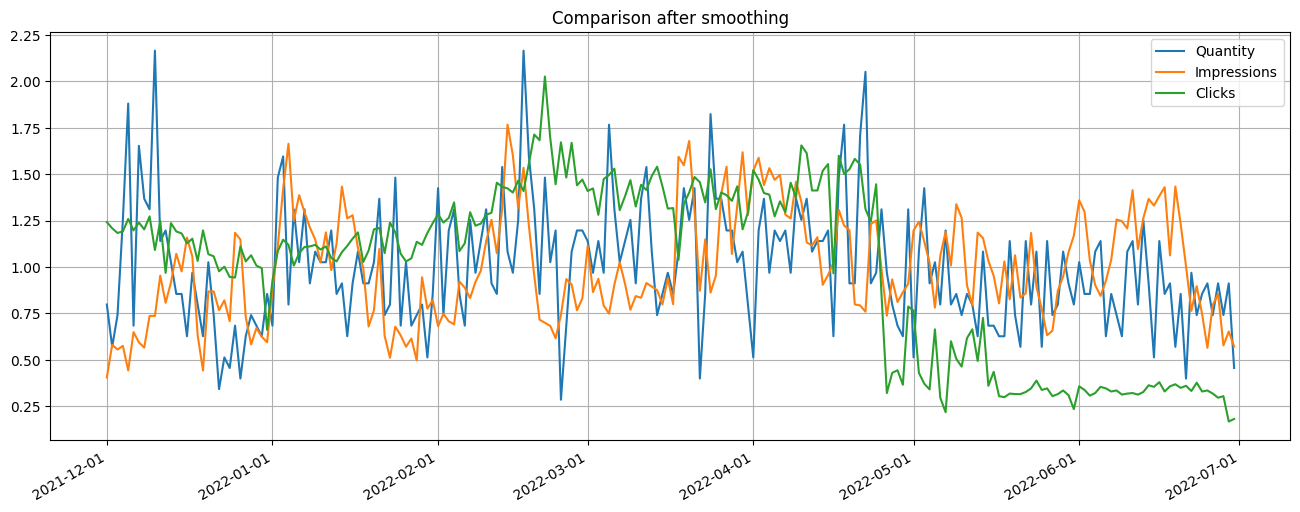

In [40]:
daily()

#### Week-Days

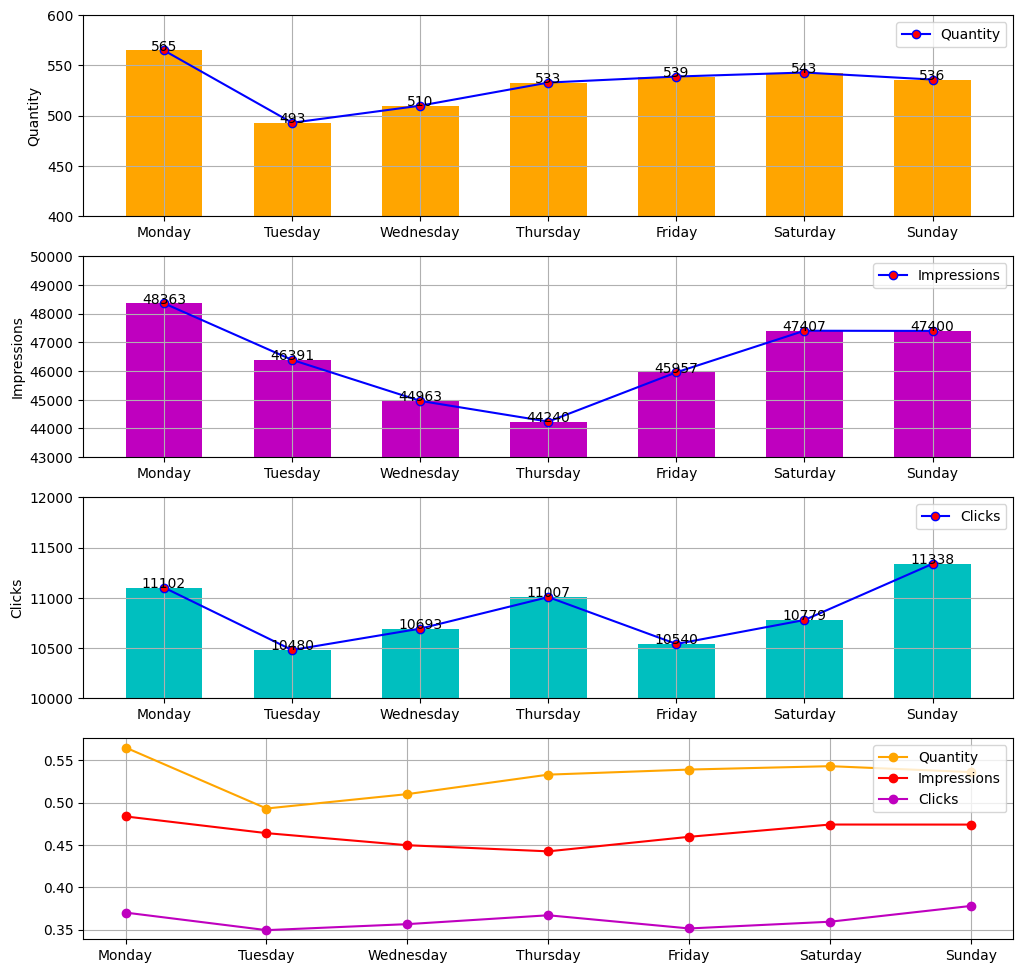

In [41]:
weekDays = weekdays()

**Note:**
- `Monday` to `Thursday` Quantity follow similar pattern as Clicks
- Similarly from `Thursday` to `Sunday` Quantity follows pattern as Impressions
- Strong positive correlation between all the three i.e.
    - Between Quantity and Clicks
    - Between Quantity and Impressions
    - Between Clicks and Impressions

#### Weekly

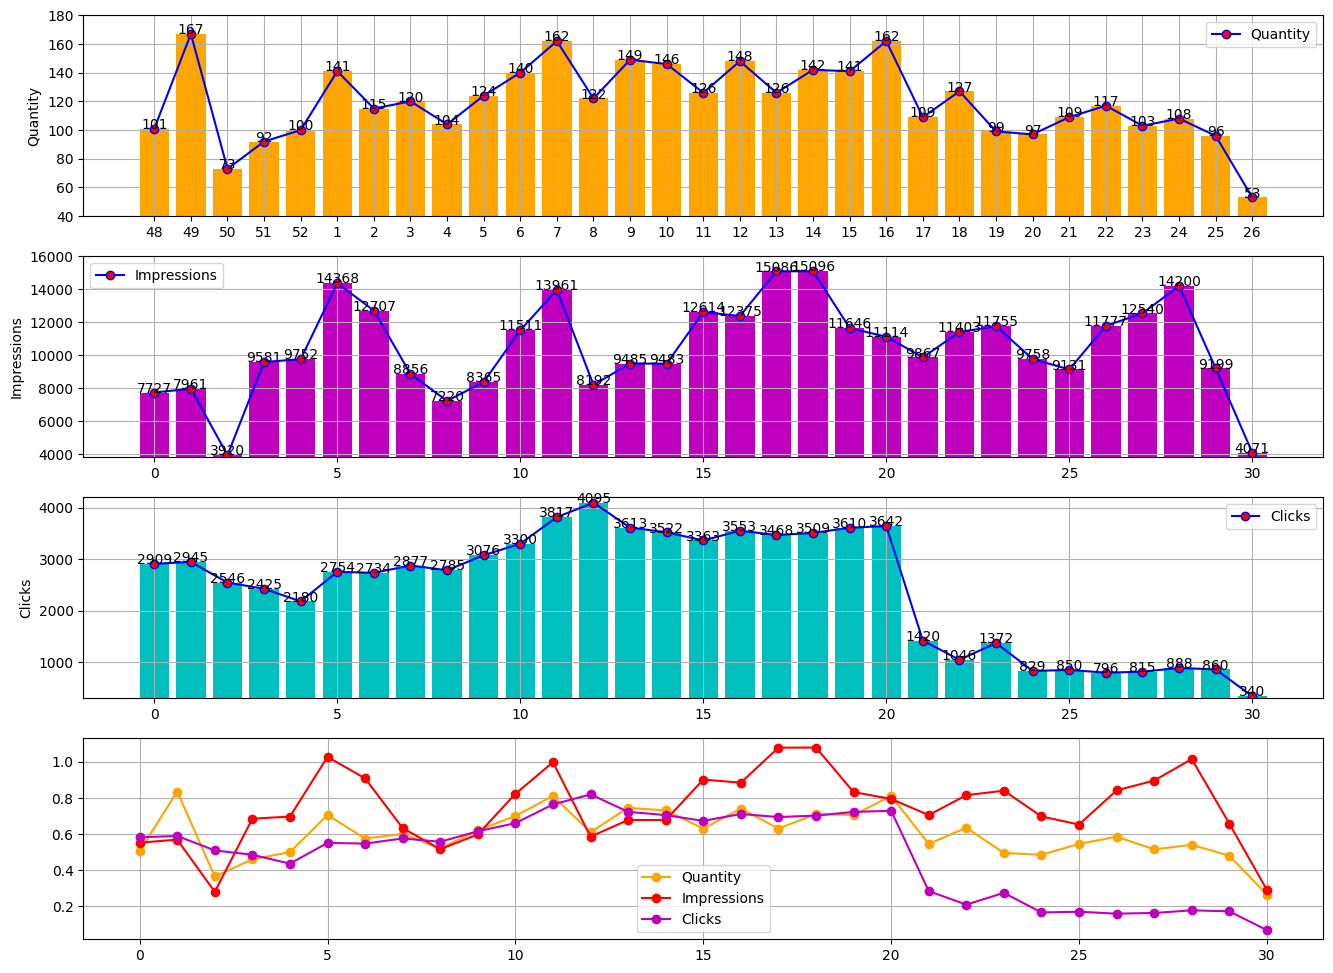

In [42]:
weekWiseData = weekwise()

**Note:**
- We can observe that from `WEEK-1` to `WEEK-14` Qunatity and Impressions have same pattern
- Similarly from `WEEK-14` to `WEEK-21` Qunatity and Clicks follow same pattern
- After `WEEK-27` Quantity, Impressions and Clicks falls.
- Relation between `Quantity` and `Clicks` has improved
- There is low `negative` in correlation between `Quantity` and `Impressions` & `Clicks` and `Impressions`

#### Monthly

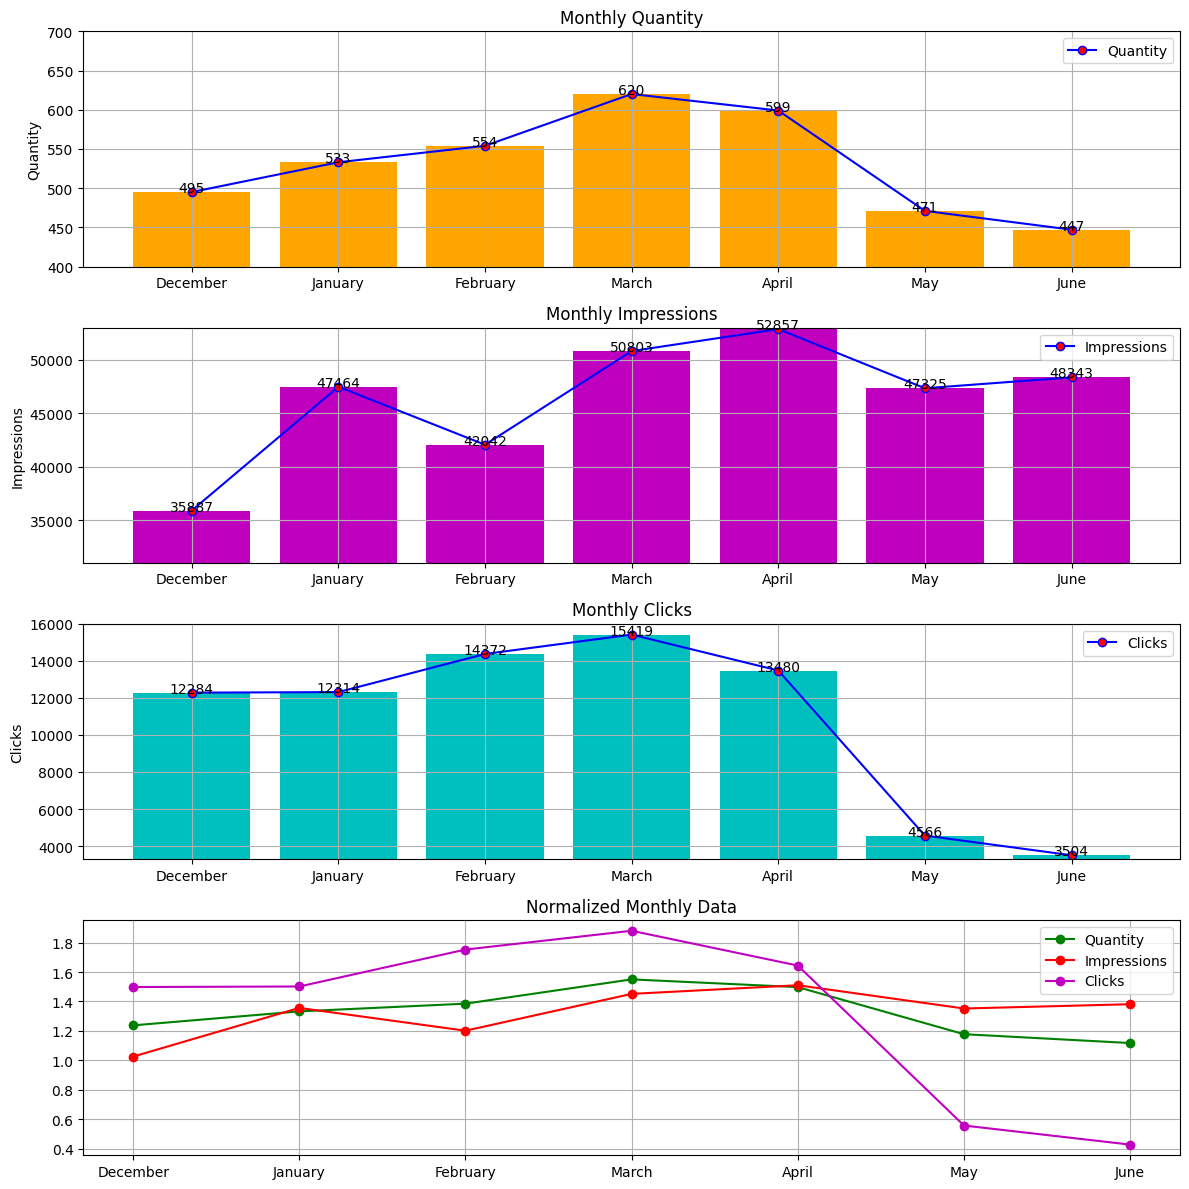

In [43]:
monthlyData = months(product_clicks_impression)

**Note:**
- `Quantity` and `Clicks` show same behaviour over 7 months
- Last 2 month `Quantity`, `Impressions` and `Clicks` fall

### Hypothesis Testing

We can check stationarity of data by following ways:
1. Visualisation
2. Statistical Tests:
    1. *ADF Test*
    2. *KPSS Test*
- Conclusions that can be drawn from Statistical Tests:
    - `Case 1`: **Both** tests conclude that the given series is **stationary** – The series is `stationary`
    - `Case 2`: **Both** tests conclude that the given series is **non-stationary** – The series is `non-stationary`
    - `Case 3`: ADF concludes **non-stationary**, and KPSS concludes **stationary** – The series is `trend stationary`. 
    - `Case 4`: ADF concludes **stationary**, and KPSS concludes **non-stationary** – The series is `difference stationary`.

#### 1. Stationarity

##### 1.1 Quantity

In [44]:
print(adf_test(product_clicks_impression['Quantity']))
print(kpss_test(product_clicks_impression['Quantity']))

Results of Dickey-Fuller Test:
Test Statistic                  -4.445717
p-value                          0.000246
#Lags Used                       3.000000
Number of Observations Used    208.000000
Critical Value (1%)             -3.462186
Critical Value (5%)             -2.875538
Critical Value (10%)            -2.574231
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.322623
p-value                  0.100000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Quantity` data is stationary.

##### 1.2 Impressions

In [45]:
print(adf_test(product_clicks_impression['Impressions']))
print(kpss_test(product_clicks_impression['Impressions']))

Results of Dickey-Fuller Test:
Test Statistic                -5.696206e+00
p-value                        7.863580e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.110000e+02
Critical Value (1%)           -3.461727e+00
Critical Value (5%)           -2.875337e+00
Critical Value (10%)          -2.574124e+00
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.351808
p-value                  0.097928
#Lags Used               8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Impressions` data is stationary.

##### 1.3 Clicks

In [46]:
print(adf_test(product_clicks_impression['Clicks']))
print(kpss_test(product_clicks_impression['Clicks']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.870572
p-value                          0.797509
#Lags Used                       2.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64
None
Results of KPSS Test:
Test Statistic           1.171045
p-value                  0.010000
#Lags Used               9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


- `Clicks` data is non-stationary.

Converting Non-Stationary Data into Stationary Data

In [47]:
product_clicks_impression_update['Clicks_diff_1'] = product_clicks_impression_update['Clicks'].diff(1)
product_clicks_impression_update['Clicks_diff_1'][0] = 0
product_clicks_impression_update['Clicks_diff_2'] = product_clicks_impression_update['Clicks'].diff(2)
product_clicks_impression_update['Clicks_diff_2'][0] = 0
product_clicks_impression_update['Clicks_diff_2'][1] = -12

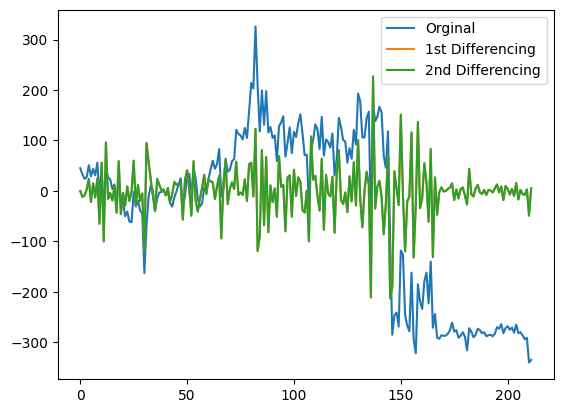

Results of Dickey-Fuller Test:
Test Statistic                  -4.144415
p-value                          0.000817
#Lags Used                      15.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64
None
Results of KPSS Test:
Test Statistic           0.135368
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
None


,Day Index,Quantity,Clicks,Impressions,Quantity_new_95_5,Quantity_new_97_5,Clicks_diff_1,Clicks_diff_2
0,2021-12-01,14,445,620,14.00,14.00,0.0,0.0
1,2021-12-02,10,433,890,10.00,10.00,-12.0,-12.0
2,2021-12-03,13,424,851,13.00,13.00,-9.0,-21.0
3,2021-12-04,22,427,881,22.00,22.00,3.0,-6.0
4,2021-12-05,33,451,678,27.45,30.67,24.0,27.0


In [48]:
product_clicks_impression['Clicks_diff_1'] = product_clicks_impression['Clicks'].diff(1)
product_clicks_impression['Clicks_diff_1'][0] = 0
product_clicks_impression['Clicks_diff_2'] = product_clicks_impression['Clicks'].diff(2)
product_clicks_impression['Clicks_diff_2'][0] = 0
product_clicks_impression['Clicks_diff_2'][1] = -12

plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks'].sub(400), label = 'Orginal')
plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks_diff_1'], label = '1st Differencing')
plt.plot(product_clicks_impression.index, product_clicks_impression['Clicks_diff_1'], label = '2nd Differencing')
plt.legend()
plt.show()
print(adf_test(product_clicks_impression['Clicks_diff_2']))
print(kpss_test(product_clicks_impression['Clicks_diff_2']))
product_clicks_impression.head()

- `Clicks` data achives stationarity after `2nd` order differencing

#### 2. Trend and Seasonality

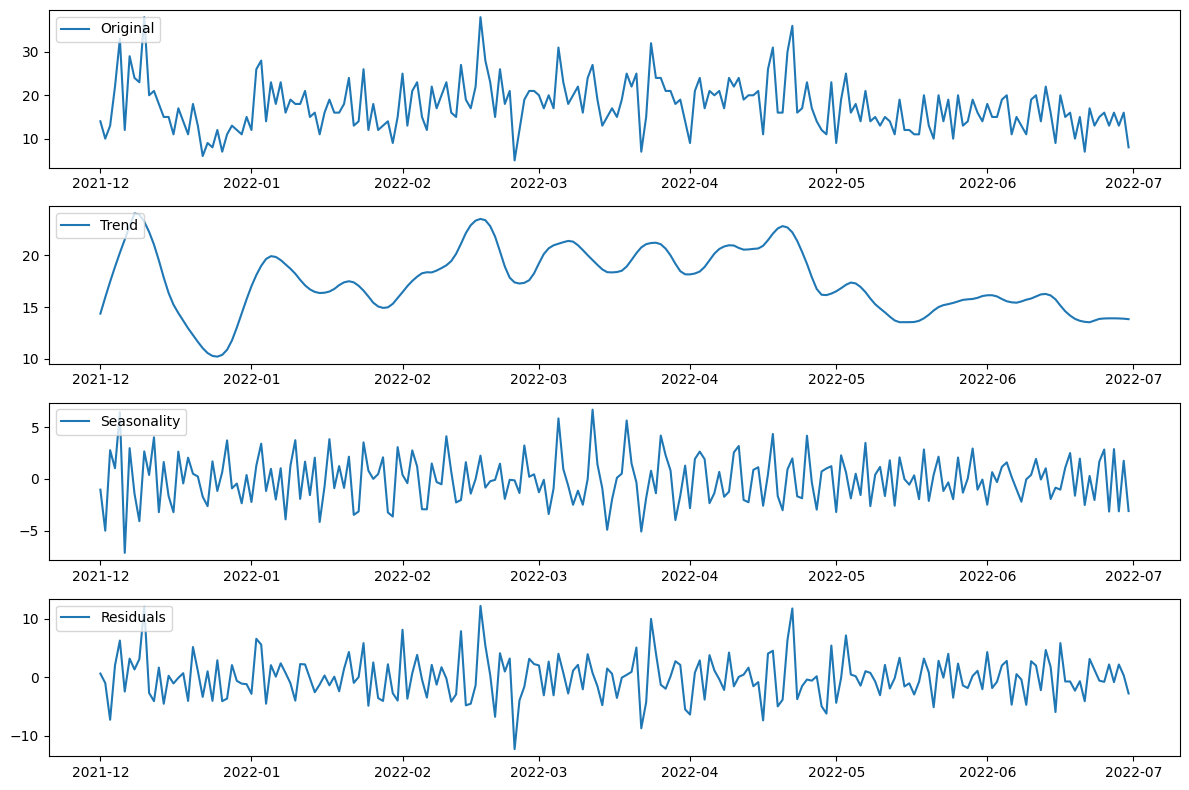

In [49]:
product_clicks_impression_update_1 = product_clicks_impression.set_index('Day Index')
seasonal_period = 7  
stl = STL(product_clicks_impression_update_1['Quantity'], seasonal=seasonal_period)
result = stl.fit()
# Plotting the components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(product_clicks_impression_update_1['Quantity'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [50]:
import pymannkendall as mk
mk.original_test(product_clicks_impression['Quantity'])

Mann_Kendall_Test(trend='no trend', h=False, p=0.1479645859286245, z=-1.446758456124471, Tau=-0.06670839667352231, s=-1492.0, var_s=1062094.6666666667, slope=-0.0078125, intercept=17.82421875)

- `No` Trend found in Quantity

#### 3. Lagged Effects over Quantity

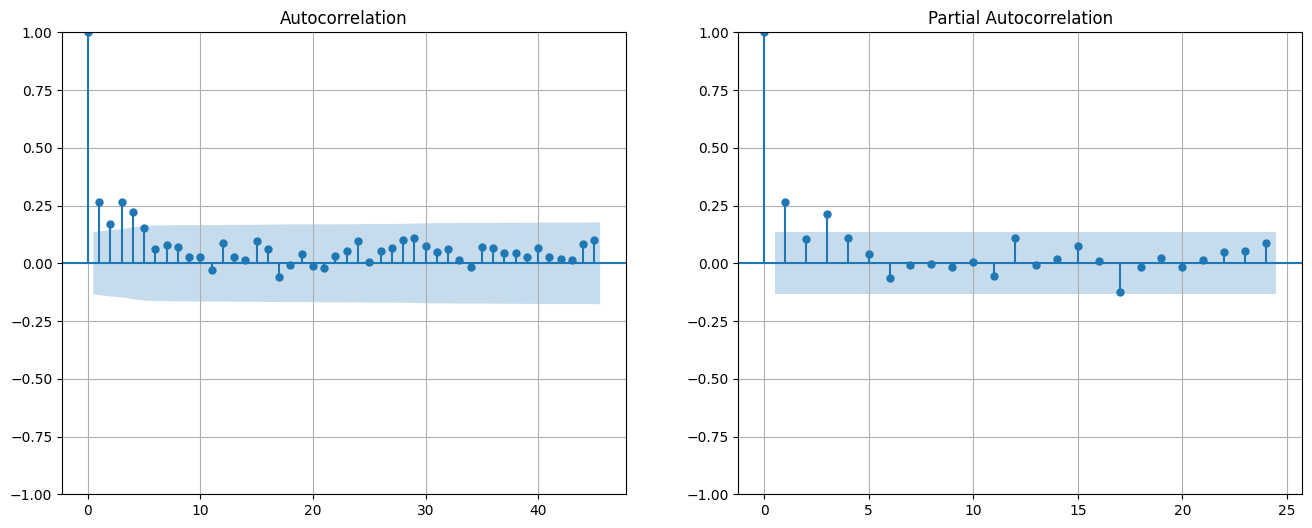

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(product_clicks_impression['Quantity'], lags=45, ax=axes[0])
axes[0].grid(True)
plot_pacf(product_clicks_impression['Quantity'], ax=axes[1])
plt.grid(True)
plt.show()

- ACF Lag - `1`, `3`, `4`
- PACF Lags - `1`, `3`

### Split Ratio for Model Training & Evaluation

Dataset For | Split Ratio-1 | Split Ratio-2
--- | --- | --- |
Training | 60% | 80%|
Validating | 20% | 10%
Testing | 20% | 10%|

### Basic Time Series Models

#### Auto Regression (AR) Model

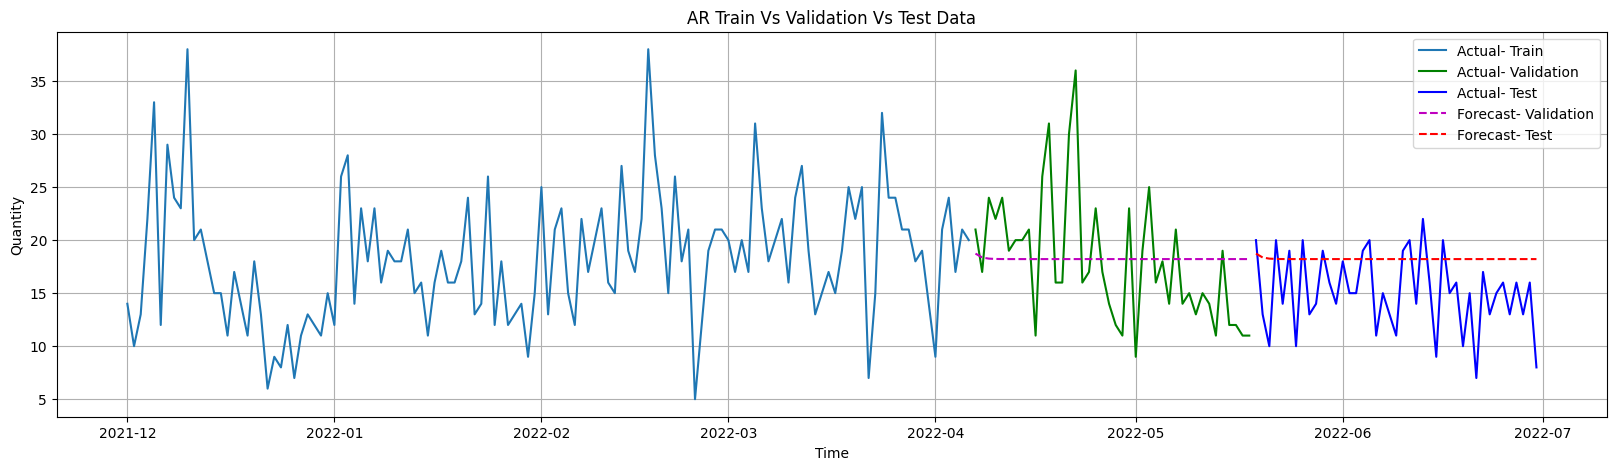

Validation Data: 
MAE  : 4.782, RMSE  : 5.9462, MAPE  : 29.2645%, R-Square:  0.0007,  Adjusted R-Square  : -0.0243
Test Data: 
MAE  : 3.9332, RMSE  : 4.7857, MAPE  : 33.368, R-Square : -0.7411, Adjusted R-Square : -0.7836


In [52]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,0,product_clicks_impression,'Quantity', 0.60, 0.20)

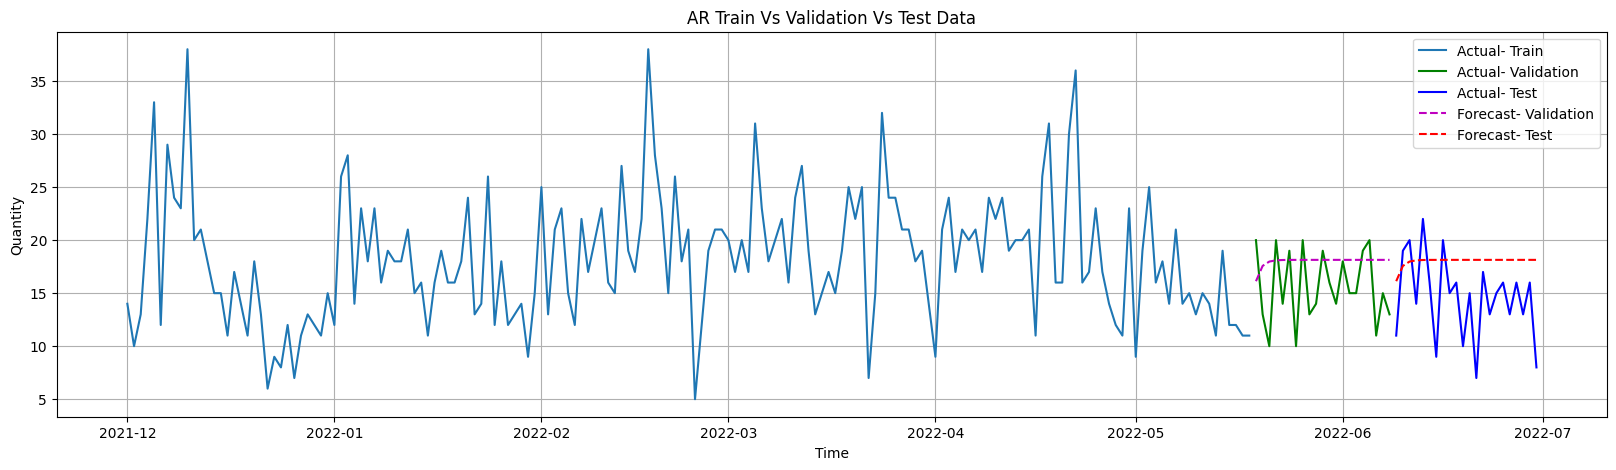

Validation Data: 
MAE  : 3.5379, RMSE  : 4.1853, MAPE  : 26.9987%, R-Square:  -0.5928,  Adjusted R-Square  : -0.6766
Test Data: 
MAE  : 4.2559, RMSE  : 5.1225, MAPE  : 38.3691, R-Square : -0.7855, Adjusted R-Square : -0.8747


In [53]:
AR = AR_MA_ARIMA_Model_TestingAndValidation(1,0,0,product_clicks_impression,'Quantity', 0.80, 0.10)

#### Moving Average (MA) Model

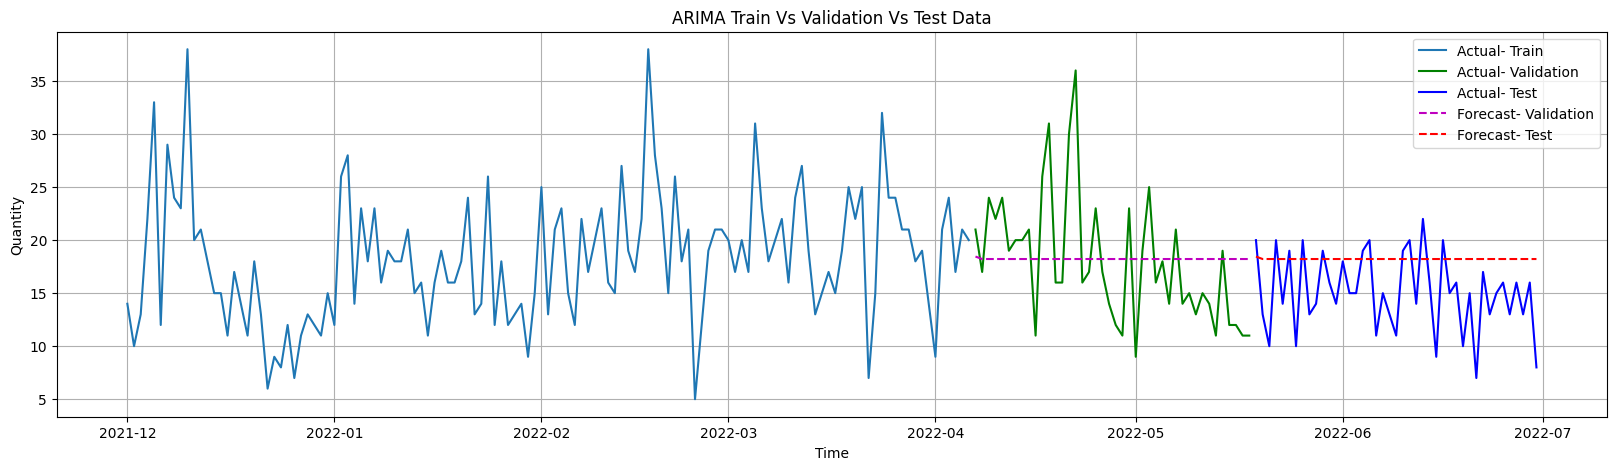

Validation Data: 
MAE  : 4.7876, RMSE  : 5.9497, MAPE  : 29.2973%, R-Square:  -0.0005,  Adjusted R-Square  : -0.0255
Test Data: 
MAE  : 3.9387, RMSE  : 4.7862, MAPE  : 33.3935, R-Square : -0.7414, Adjusted R-Square : -0.7839


In [54]:
MA = AR_MA_ARIMA_Model_TestingAndValidation(0,0,1,product_clicks_impression,'Quantity', 0.60, 0.20)

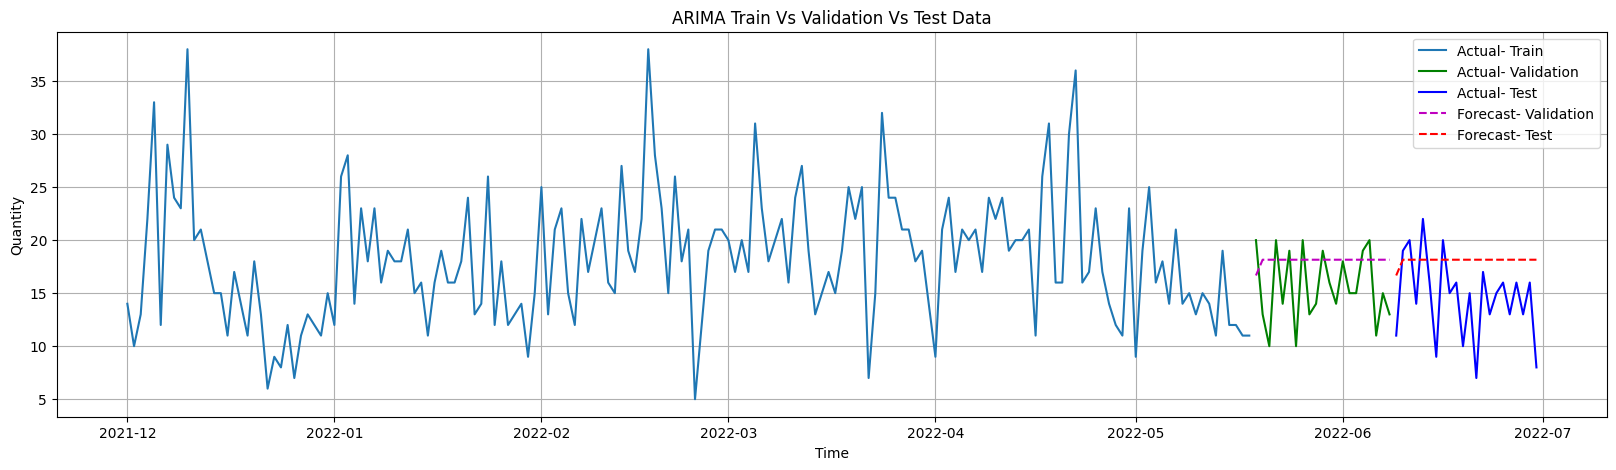

Validation Data: 
MAE  : 3.5503, RMSE  : 4.2173, MAPE  : 27.1958%, R-Square:  -0.6172,  Adjusted R-Square  : -0.7023
Test Data: 
MAE  : 4.2573, RMSE  : 5.1498, MAPE  : 38.5064, R-Square : -0.8046, Adjusted R-Square : -0.8948


In [55]:
MA = AR_MA_ARIMA_Model_TestingAndValidation(0,0,1,product_clicks_impression,'Quantity', 0.80, 0.10)

#### Auto Regression Integrated Moving Average (ARIMA) Model

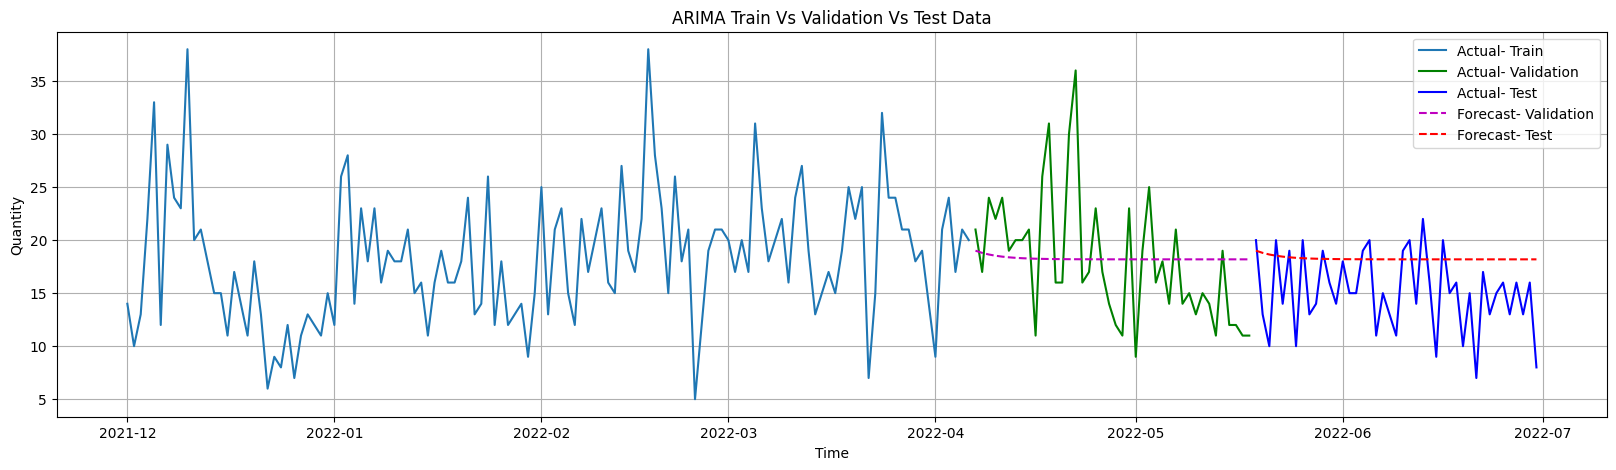

Validation Data: 
MAE  : 4.7468, RMSE  : 5.9204, MAPE  : 29.086%, R-Square:  0.0093,  Adjusted R-Square  : -0.0155
Test Data: 
MAE  : 3.9337, RMSE  : 4.8087, MAPE  : 33.4362, R-Square : -0.7579, Adjusted R-Square : -0.8008


In [56]:
ARIMA = AR_MA_ARIMA_Model_TestingAndValidation(1,0,1,product_clicks_impression,'Quantity', 0.60, 0.20)

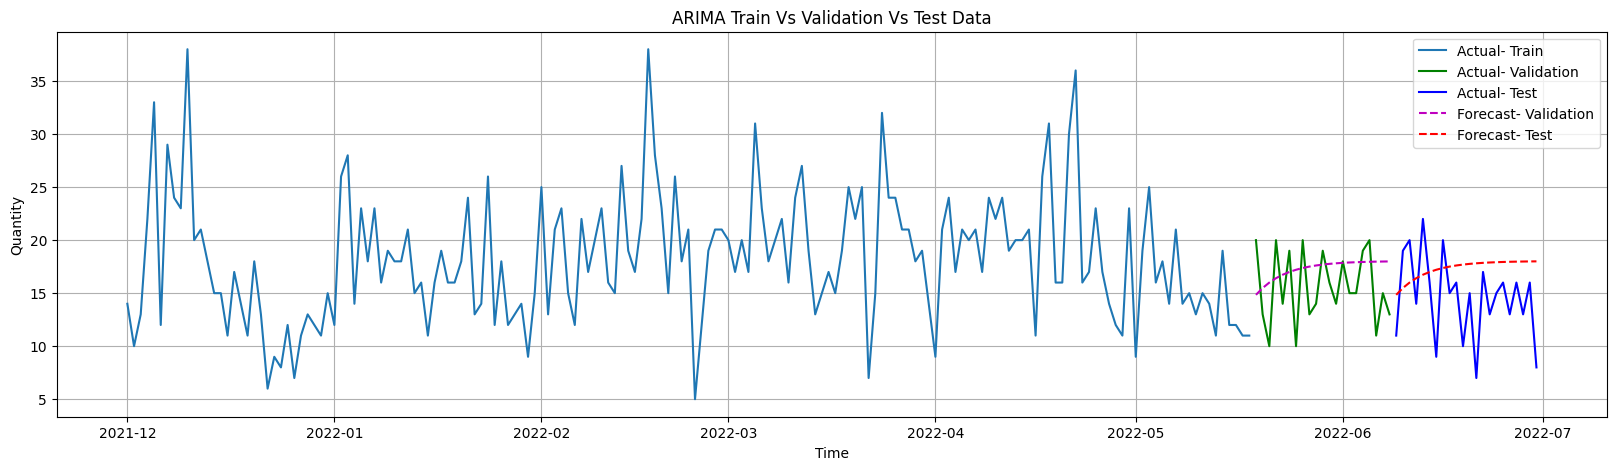

Validation Data: 
MAE  : 3.3717, RMSE  : 3.838, MAPE  : 24.796%, R-Square:  -0.3394,  Adjusted R-Square  : -0.4099
Test Data: 
MAE  : 4.1256, RMSE  : 4.9486, MAPE  : 36.4661, R-Square : -0.6663, Adjusted R-Square : -0.7496


In [59]:
ARIMA = AR_MA_ARIMA_Model_TestingAndValidation(1,0,1,product_clicks_impression,'Quantity', 0.80, 0.10)

#### Seasonal Auto Regression Intergrated Moving Average (SARIMA) Model

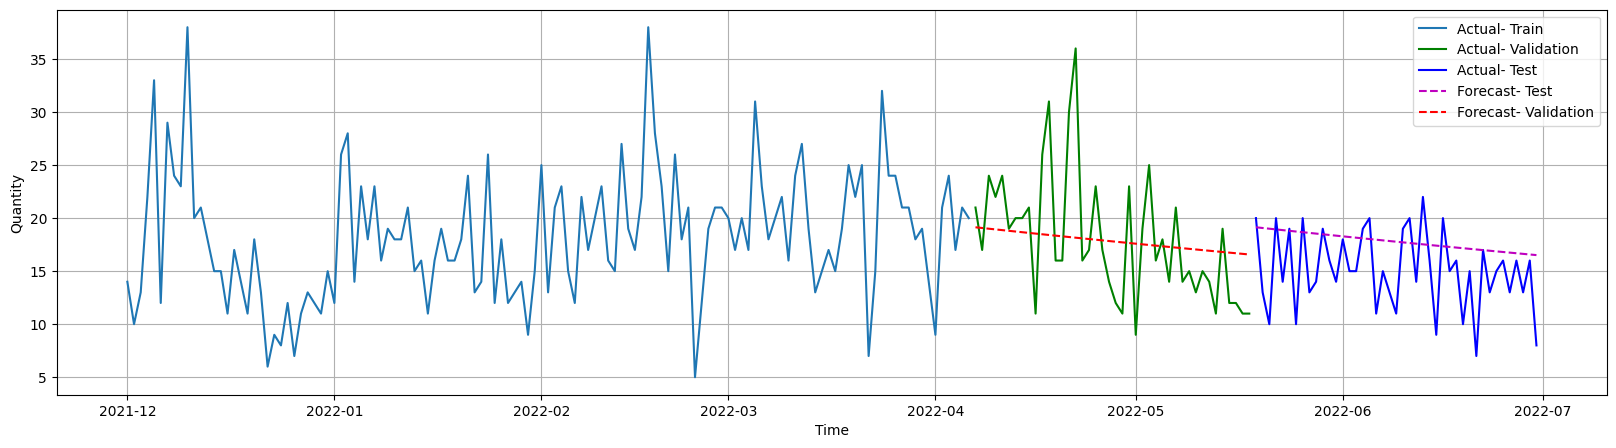

Validation Data: 
MAE  : 4.3949, RMSE  : 5.6078, MAPE  : 26.1682%, R-square  : 0.1112, Adjusted R-square  : 0.089
Test Data: 
MAE  : 3.521, RMSE  : 4.4552, MAPE  : 30.0495%, R-square  : -0.509, Adjusted R-square  : -0.5458


In [60]:
SARIMA_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity',0, 0, 0, 12)

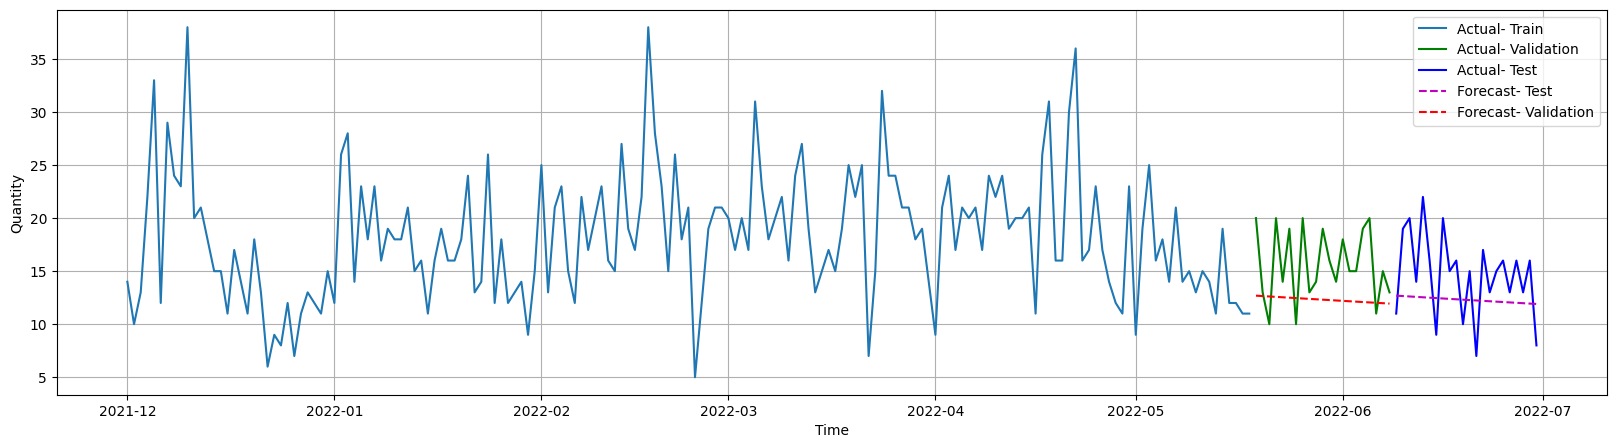

Validation Data: 
MAE  : 3.8858, RMSE  : 4.6819, MAPE  : 22.9117%, R-square  : -0.9932, Adjusted R-square  : -1.0981
Test Data: 
MAE  : 3.8057, RMSE  : 4.4113, MAPE  : 26.6348%, R-square  : -0.3241, Adjusted R-square  : -0.3903


In [61]:
SARIMA_Model(product_clicks_impression_update, 1, 0, 1, 0.80,0.10, 'Quantity',0, 0, 0, 12)

#### Auto ARIMA

In [62]:
from pmdarima import auto_arima
train_data = product_clicks_impression['Quantity']
model = auto_arima(train_data, seasonal=False, trace=True)
print(model.summary())
forecasts = model.predict()  
print(forecasts)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1339.010, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1840.056, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1423.427, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1668.562, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1337.554, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1595.146, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1337.602, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1339.535, Time=0.46 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1549.998, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1337.521, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1386.038, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1339.403, Time=0.41 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1353.871, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1340.924, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

- Auto ARIMA also prefers lag values as `p = 1` and `q = 1`

#### Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX) Model

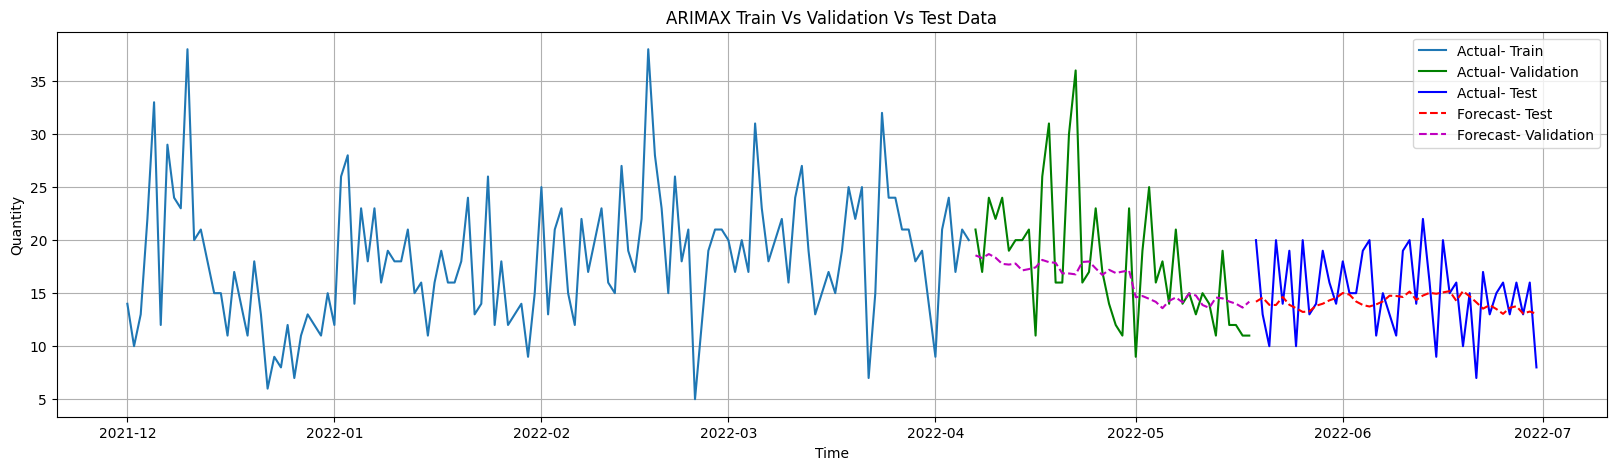

Validation Data: 
MAE  : 4.1745, RMSE  : 5.707, MAPE  : 22.2005%, R-square  : 0.0795, Adjusted R-square  : -0.0484
Test Data: 
MAE  : 2.9856, RMSE  : 3.7415, MAPE  : 21.3713%, R-square  : -0.0642, Adjusted R-square  : -0.208


In [65]:
ARIMAX = ARIMAX_Model(1, 0, 1,product_clicks_impression_update, 'Quantity', ['Impressions', 'Season_Winter', 'Month_February', 'Month_March', 'Month_April'], 0.60, 0.20)

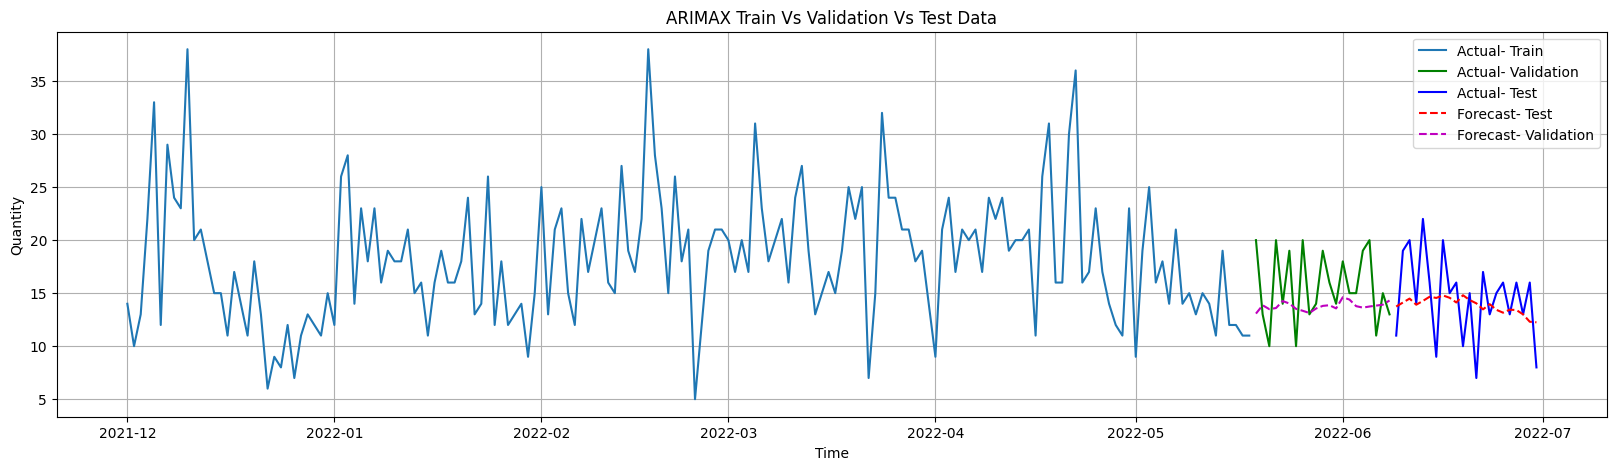

Validation Data: 
MAE  : 3.0236, RMSE  : 3.8275, MAPE  : 18.3913%, R-square  : -0.332, Adjusted R-square  : -0.665
Test Data: 
MAE  : 3.0794, RMSE  : 3.8175, MAPE  : 24.0842%, R-square  : 0.0084, Adjusted R-square  : -0.225


In [68]:
ARIMAX = ARIMAX_Model(1, 0, 1,product_clicks_impression_update, 'Quantity', ['Clicks', 'Impressions', 'Season_Winter', 'Month_February'], 0.80, 0.10)

#### Seasonal Autoregressive Integrated Moving Average with Explanatory Variable (SARIMAX) model

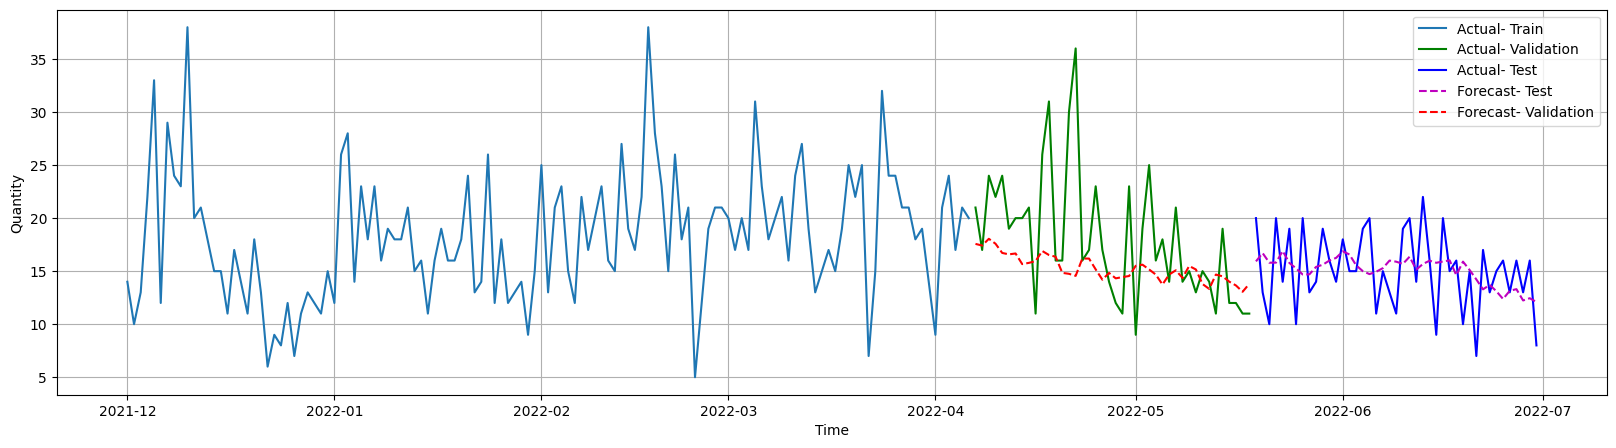

Validation Data: 
MAE  : 4.3746, RMSE  : 6.2077, MAPE  : 22.0956%, R-square  : -0.0892, Adjusted R-square  : -0.1752
Test Data: 
MAE  : 3.0229, RMSE  : 3.6107, MAPE  : 22.8221%, R-square  : 0.0089, Adjusted R-square  : -0.0673


In [78]:
SARIMAX = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.60, 0.20, 'Quantity',['Impressions', 'Month_February', 'Month_March'], 0, 0, 0, 12)

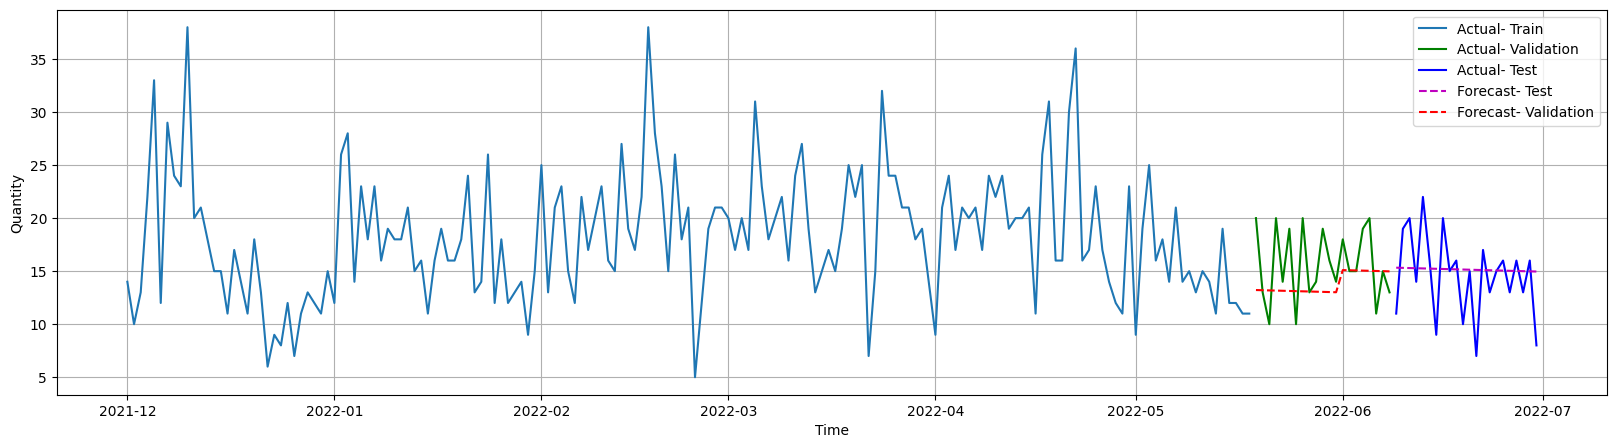

Validation Data: 
MAE  : 2.9823, RMSE  : 3.8431, MAPE  : 18.231%, R-square  : -0.343, Adjusted R-square  : -0.58
Test Data: 
MAE  : 2.9521, RMSE  : 3.8413, MAPE  : 25.4087%, R-square  : -0.004, Adjusted R-square  : -0.1714


In [79]:
SARIMAX = SARIMAX_Model(product_clicks_impression_update, 1, 0, 1, 0.80, 0.10, 'Quantity',['Month_March', 'Month_December', 'Month_May'], 0, 0, 0, 12)

#### Multiple Linear Regression (MLR) Model

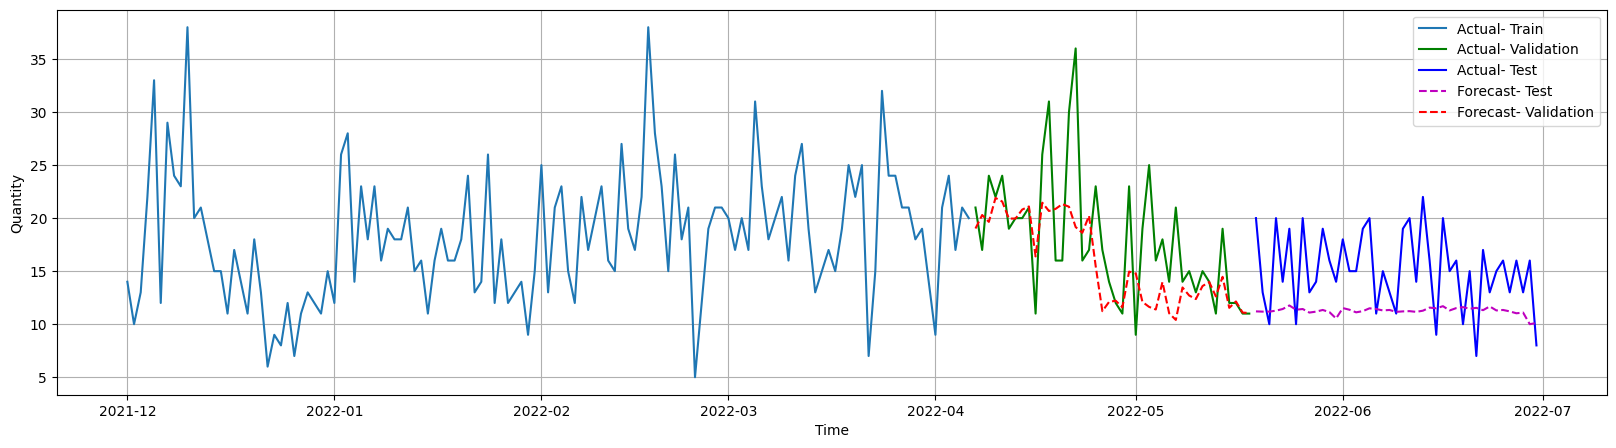

Validation Data: 
MAE  : 3.8147, RMSE  : 5.4304, MAPE  : 19.5306%, R-square  : 0.1665, Adjusted R-square  : 0.1007
Test Data: 
MAE  : 4.4784, RMSE  : 5.2483, MAPE  : 27.8572%, R-square  : -1.094, Adjusted R-square  : -1.2551


In [85]:
MLR = MLR_Model(product_clicks_impression_update, 'Quantity', 0.60, 0.20, ['Clicks', 'Season_Winter', 'Month_December'])

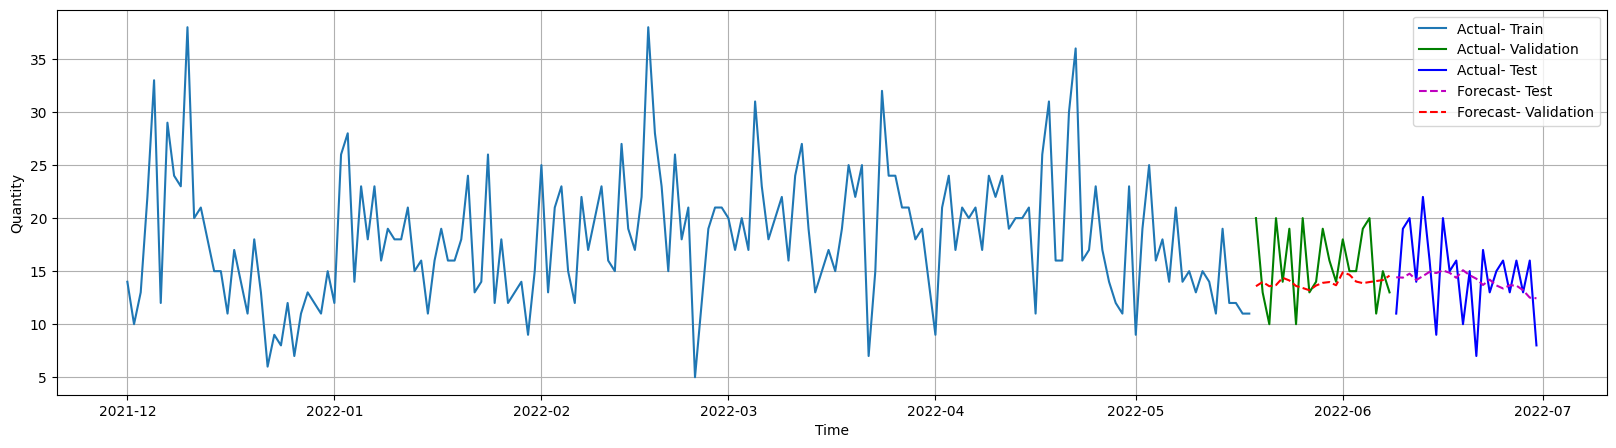

Validation Data: 
MAE  : 2.9428, RMSE  : 3.7253, MAPE  : 18.0461%, R-square  : -0.2619, Adjusted R-square  : -0.8027
Test Data: 
MAE  : 3.0413, RMSE  : 3.7927, MAPE  : 24.2897%, R-square  : 0.0212, Adjusted R-square  : -0.3703


In [91]:
MLR = MLR_Model(product_clicks_impression_update, 'Quantity', 0.80, 0.10, ['Clicks', 'Impressions', 'Season_Winter', 'Month_February', 'Month_March', 'Month_May'])

## REPORT:

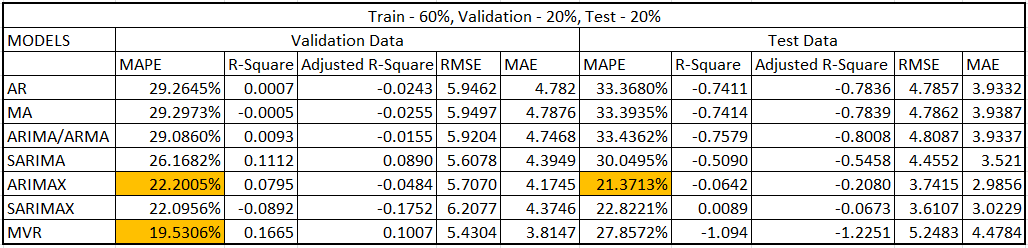

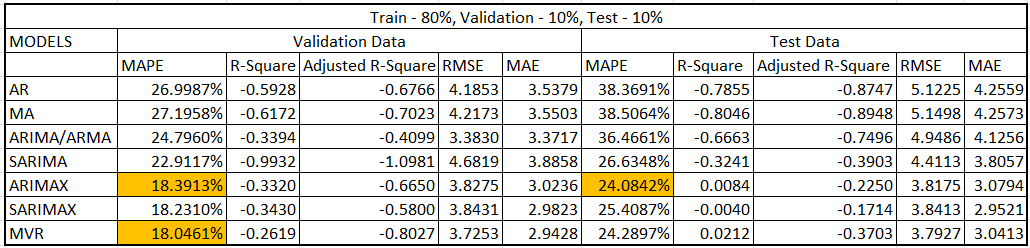